## CARDIOVASCULAR DISEASE KNN CLASSIFICATION MODEL 

**INTRODUCTION**

According to the World Health Organization, cardiovascular disease is the leading global cause of death. In fact, over 17.9 million patients die from the disease each year (Centers for Disease Control and Prevention, 2022). Cardiovascular disease is characterized by high blood pressure, cholesterol and chest pain leading to heart failure, arrhythmia and heart attack symptoms (World Health Organization, 2023).

Due to the growing prevalence of machine learning algorithms in the health care sector, our goal is to create and train a model using the KNN classification algorithm that will predict whether individuals are likely to have cardiovascular disease based on various clinical attributes. 

**Research question**: Which individuals are likely to have cardiovascular disease according to various clinical attributes?

The "hungarian heart disease" dataset obtained from the machine learning repository contains 294 observations representing the patients of the study. It has 14 columns with various clinical attributes associated with cardiovascular disease as well as the patient's diagnosis (UCI Machine Learning Respository, 2023).

In [3]:
library(tidyverse)
library(tidymodels)
set.seed(123)

**PRELIMINARY DATA ANALYSIS**

We begin by loading the dataset into R and adding column names. The dataset is already in tidy format so we can mutate each variable to the correct data type.   

In [4]:
heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names = FALSE)

heart_data_renamed <- rename(heart_data, 
                        age = X1, 
                        sex = X2, 
                        chest_pain_type= X3, 
                        resting_blood_pressure = X4, 
                        serum_cholestoral = X5, 
                        fasting_blood_sugar = X6, 
                        resting_electrocardiographic_results = X7, 
                        max_heart_rate = X8, 
                        exercise_induced_angina = X9, 
                        oldpeak = X10, 
                        slope = X11, 
                        number_vessels = X12, 
                        thal = X13, 
                        diagnosis = X14)            

heart_data_renamed <- heart_data_renamed |>
    mutate(across(c(diagnosis, sex, chest_pain_type, fasting_blood_sugar, resting_electrocardiographic_results,exercise_induced_angina), as.factor))|>
    mutate(across(c(resting_blood_pressure), as.numeric))
head(heart_data_renamed)


Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,chest_pain_type,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,oldpeak,slope,number_vessels,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<chr>,<fct>,<fct>,<chr>,<fct>,<dbl>,<chr>,<chr>,<chr>,<fct>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


We can create a new dataframe with the following variables: age, resting blood pressure, blood cholestoral, maximum heart rate, and diagnosis variables. These are the variables that we will explore as potential variables on which to train the model. We choose to examine these variables because they are numeric and have minimal missing values. We can then filter out any remaining observations with missing values. 

In [5]:
 tidy_heart_data <- heart_data_renamed  |>
    select(age, resting_blood_pressure, serum_cholestoral, max_heart_rate, diagnosis) |>
    filter(age != "?", resting_blood_pressure != "?", serum_cholestoral != "?", max_heart_rate != "?", diagnosis != "?")
head(tidy_heart_data)

age,resting_blood_pressure,serum_cholestoral,max_heart_rate,diagnosis
<dbl>,<dbl>,<chr>,<chr>,<fct>
28,130,132,185,0
29,120,243,160,0
30,170,237,170,0
31,100,219,150,0
32,105,198,165,0
32,110,225,184,0


Using our tidy dataframe, we can divide our dataset into a training and testing set using set.seed for a random yet reproducible split. We choose a 75:25 split because we want to have a large training set with enough observations to create an accurate model but also enough observations in the testing set to get an accurate estimate of its prediction accuracy.  

In [6]:
split_heart_data <- initial_split(tidy_heart_data, prop = 0.75, strata = diagnosis)
training_heart_data <- training(split_heart_data)
testing_heart_data <- testing(split_heart_data)
head(training_heart_data) 
head(testing_heart_data)

age,resting_blood_pressure,serum_cholestoral,max_heart_rate,diagnosis
<dbl>,<dbl>,<chr>,<chr>,<fct>
31,100,219,150,0
32,105,198,165,0
32,110,225,184,0
32,125,254,155,0
33,120,298,185,0
34,130,161,190,0


age,resting_blood_pressure,serum_cholestoral,max_heart_rate,diagnosis
<dbl>,<dbl>,<chr>,<chr>,<fct>
28,130,132,185,0
29,120,243,160,0
30,170,237,170,0
34,150,214,168,0
35,150,264,168,0
36,130,209,178,0


As diagnosis is the response variable for this model, we can now use the training data to create a summary table that shows the number and percentage of observations that do and do not have a heart disease diagnosis. 

In [5]:
summary_heart_data <- training_heart_data|>
    group_by(diagnosis)|>
    summarize(Count=n())|>
    mutate(Percent = Count/201)
summary_heart_data

diagnosis,Count,Percent
<fct>,<int>,<dbl>
0,126,0.6268657
1,75,0.3731343


We can create a summary table of means for the potential predictor variables to be used in the model. 

In [7]:
summary_heart_data_2 <- training_heart_data |>
    summarize(mean_age = mean(age, na.rm = TRUE), 
                mean_blood_pressure = mean(as.numeric(resting_blood_pressure), na.rm = TRUE),
                mean_cholestoral = mean(as.numeric(serum_cholestoral), na.rm = TRUE),
                mean_max_heart_rate = mean(as.numeric(max_heart_rate), na.rm = TRUE))
summary_heart_data_2

mean_age,mean_blood_pressure,mean_cholestoral,mean_max_heart_rate
<dbl>,<dbl>,<dbl>,<dbl>
48.22388,132.2786,253.3682,140.01


This table shows that the average patient was middle-aged and had elevated blood pressures (healthy range < 120mm/Hg) and blood cholesterol (healthy levels < 200mg/dL) (UptoDate, 2023). The average maximum heart rates appear to be relatively normal according to the average adult heart rate (WebMD, 2021).

We now plot scatterplot graphs using the training data to compare the potential predictor variables to each other and examine their relationship to the response variable. The points are coloured by diagnosis and made transparent so that overlapping points can be more easily distinguished. 

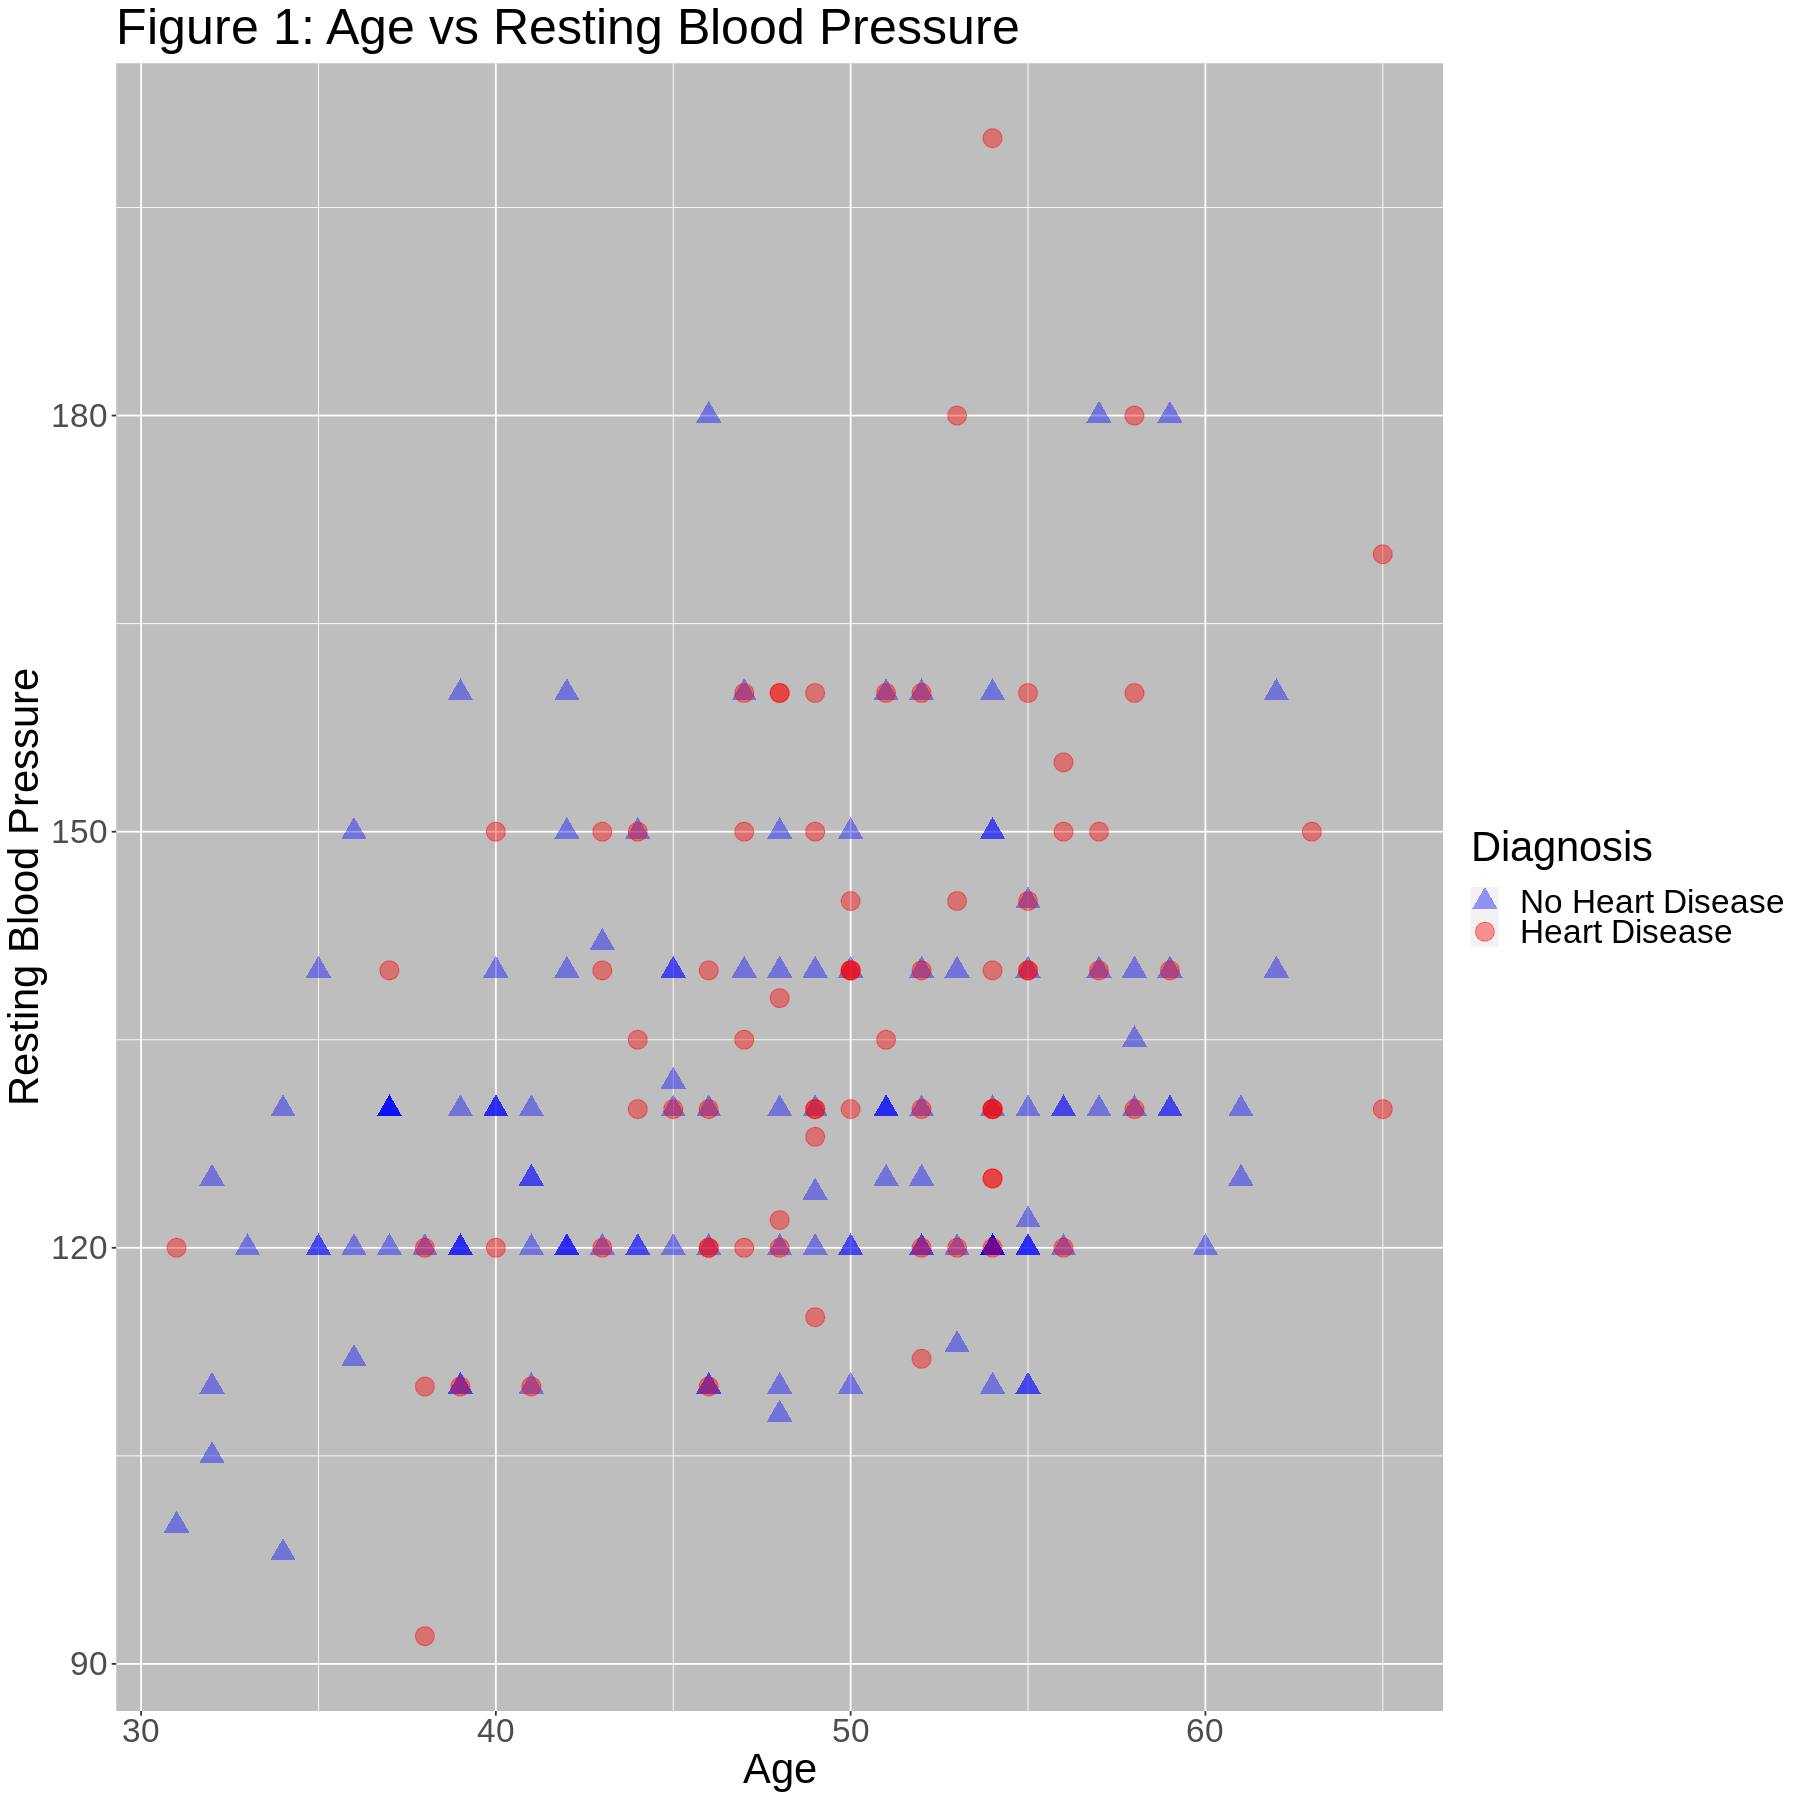

In [10]:
options(repr.plot.width = 15, repr.plot.height = 15)
age_vs_blood_pressure_plot <- training_heart_data |>
    ggplot(aes(x = age, y = as.numeric(resting_blood_pressure), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Age", y = "Resting Blood Pressure", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 25), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Figure 1: Age vs Resting Blood Pressure")
age_vs_blood_pressure_plot

This plot shows that there does not appear to be a relationship between age and resting blood pressure in relation to the diagnosis of the observations. While there is a slight clustering of points with lower age and lower resting blood presusre that have no heart disease, the diagnosed and undiagnosed data points are otherwise evenly distributed. 

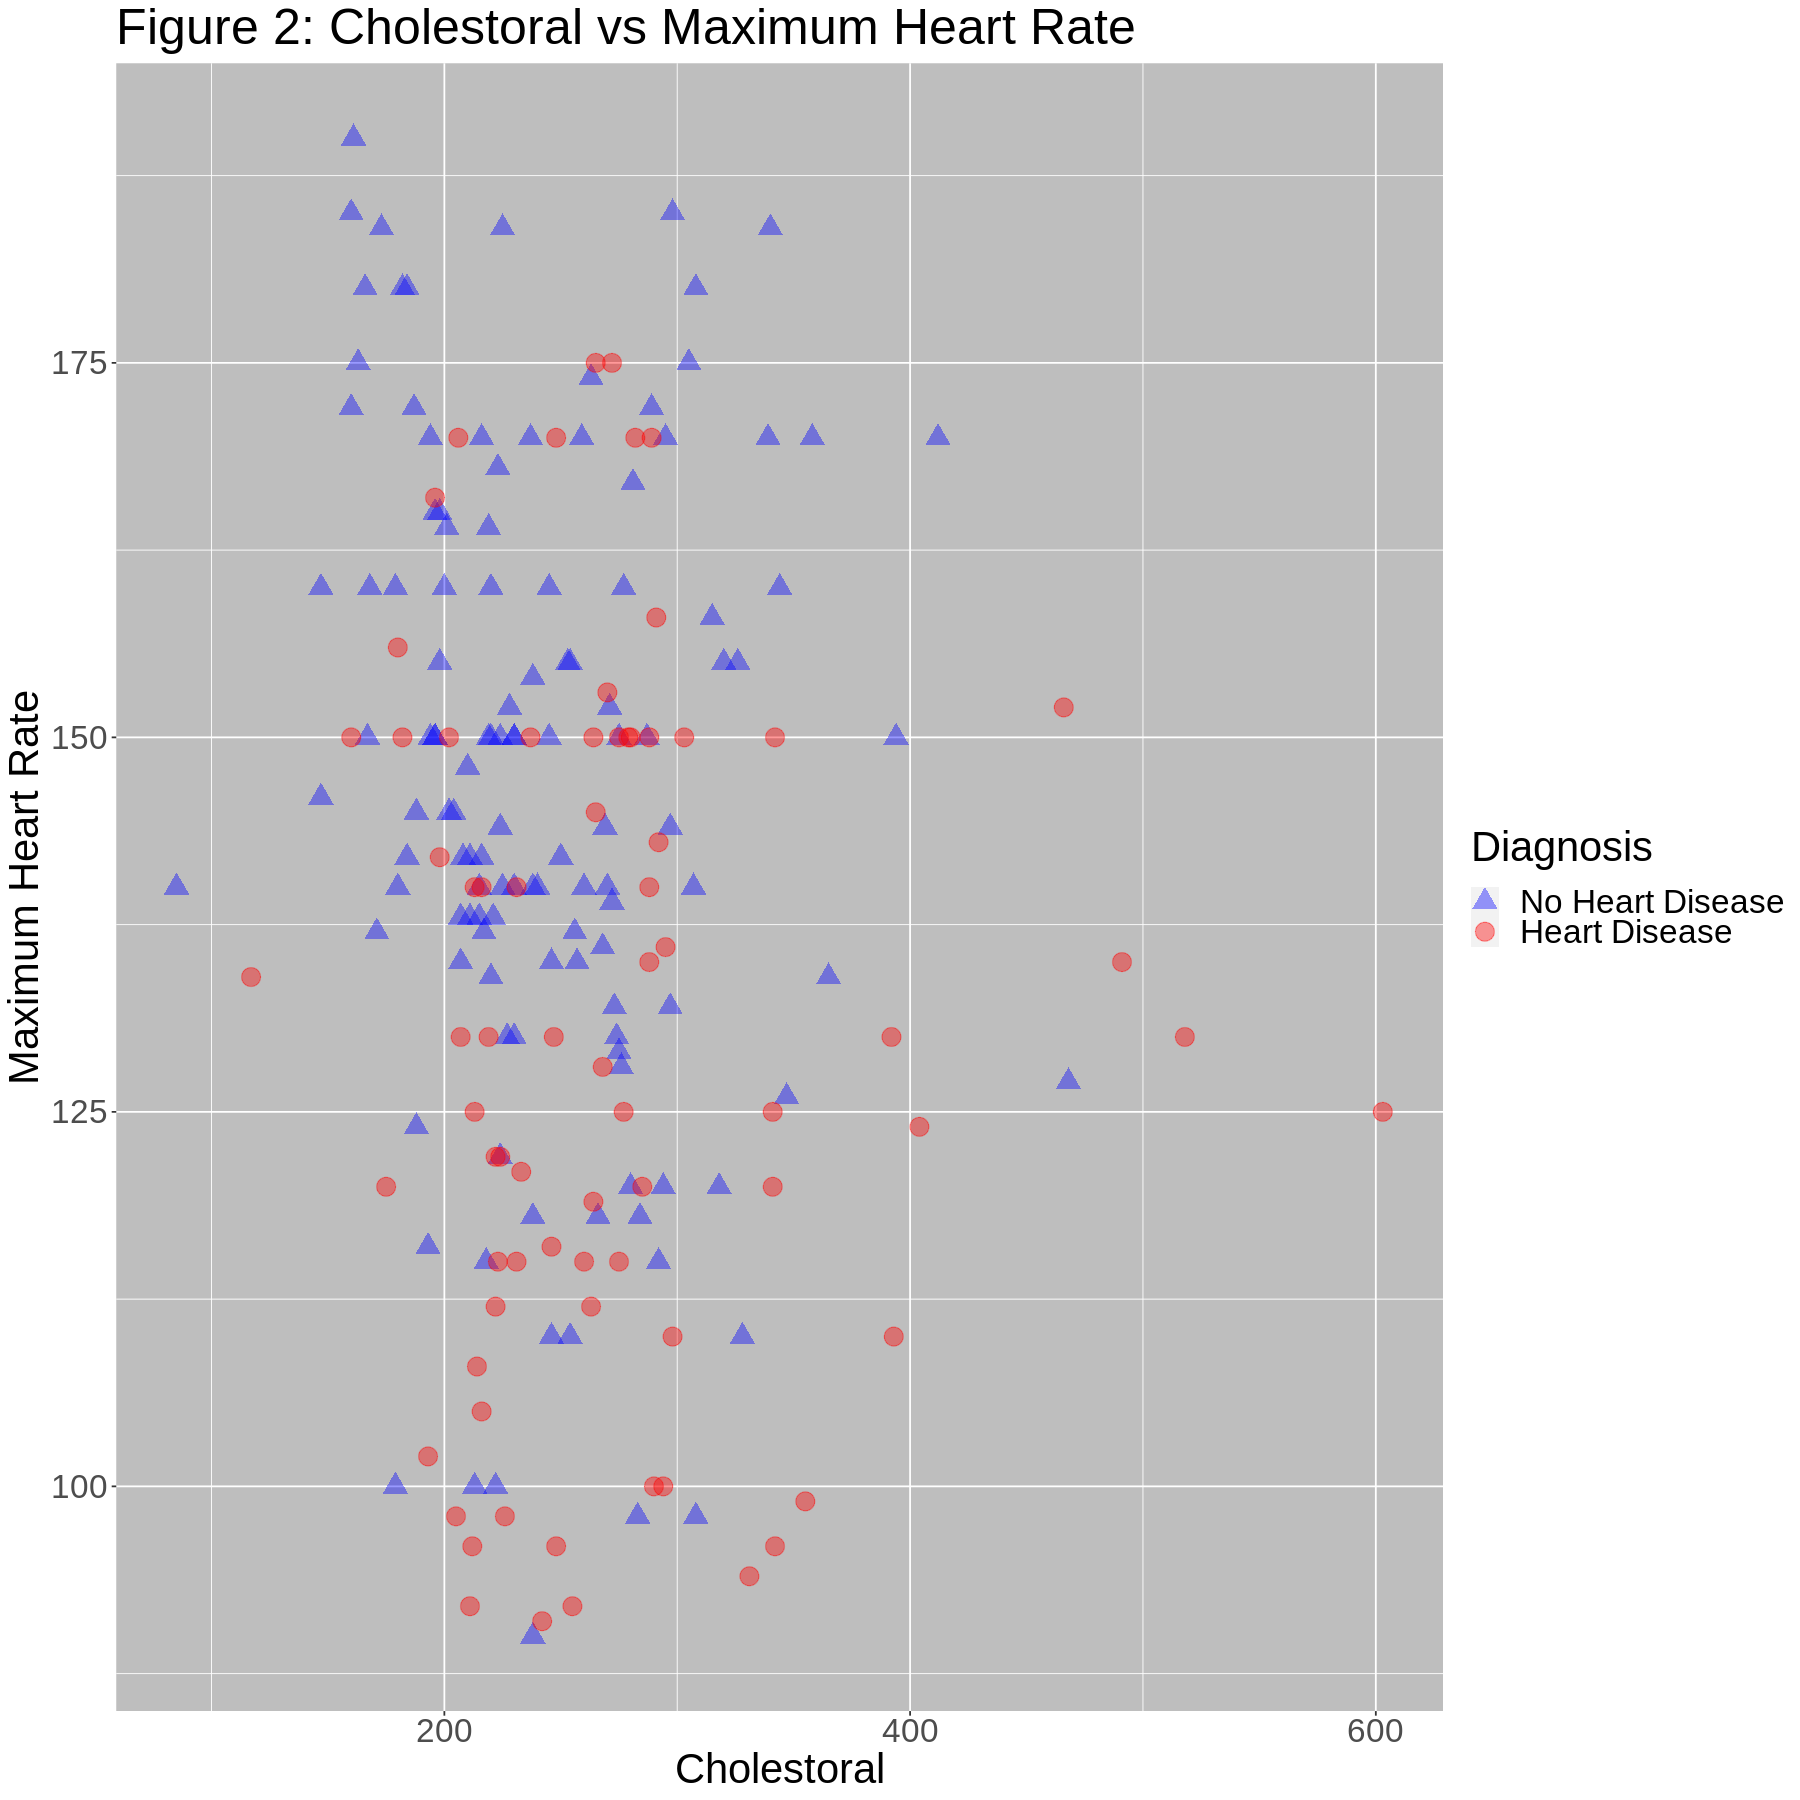

In [12]:
options(repr.plot.width = 15, repr.plot.height = 15)
age_vs_max_heart_rate_plot <- training_heart_data |>
    ggplot(aes(x = as.numeric(serum_cholestoral), y = as.numeric(max_heart_rate), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Cholestoral", y = "Maximum Heart Rate", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 25), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Figure 2: Cholestoral vs Maximum Heart Rate")
age_vs_max_heart_rate_plot 


This plot shows a clustering of data points with a higher maximum heart reate and low cholesterol that do not have heart disease. In contrast, there appears to be more data points with lower maximum heart rate and higher cholesterol that do have heart disease. Hence, is a general relationship that a lower maximum heart rate and higher cholestoral results in patients being more likely to have heart disease. 

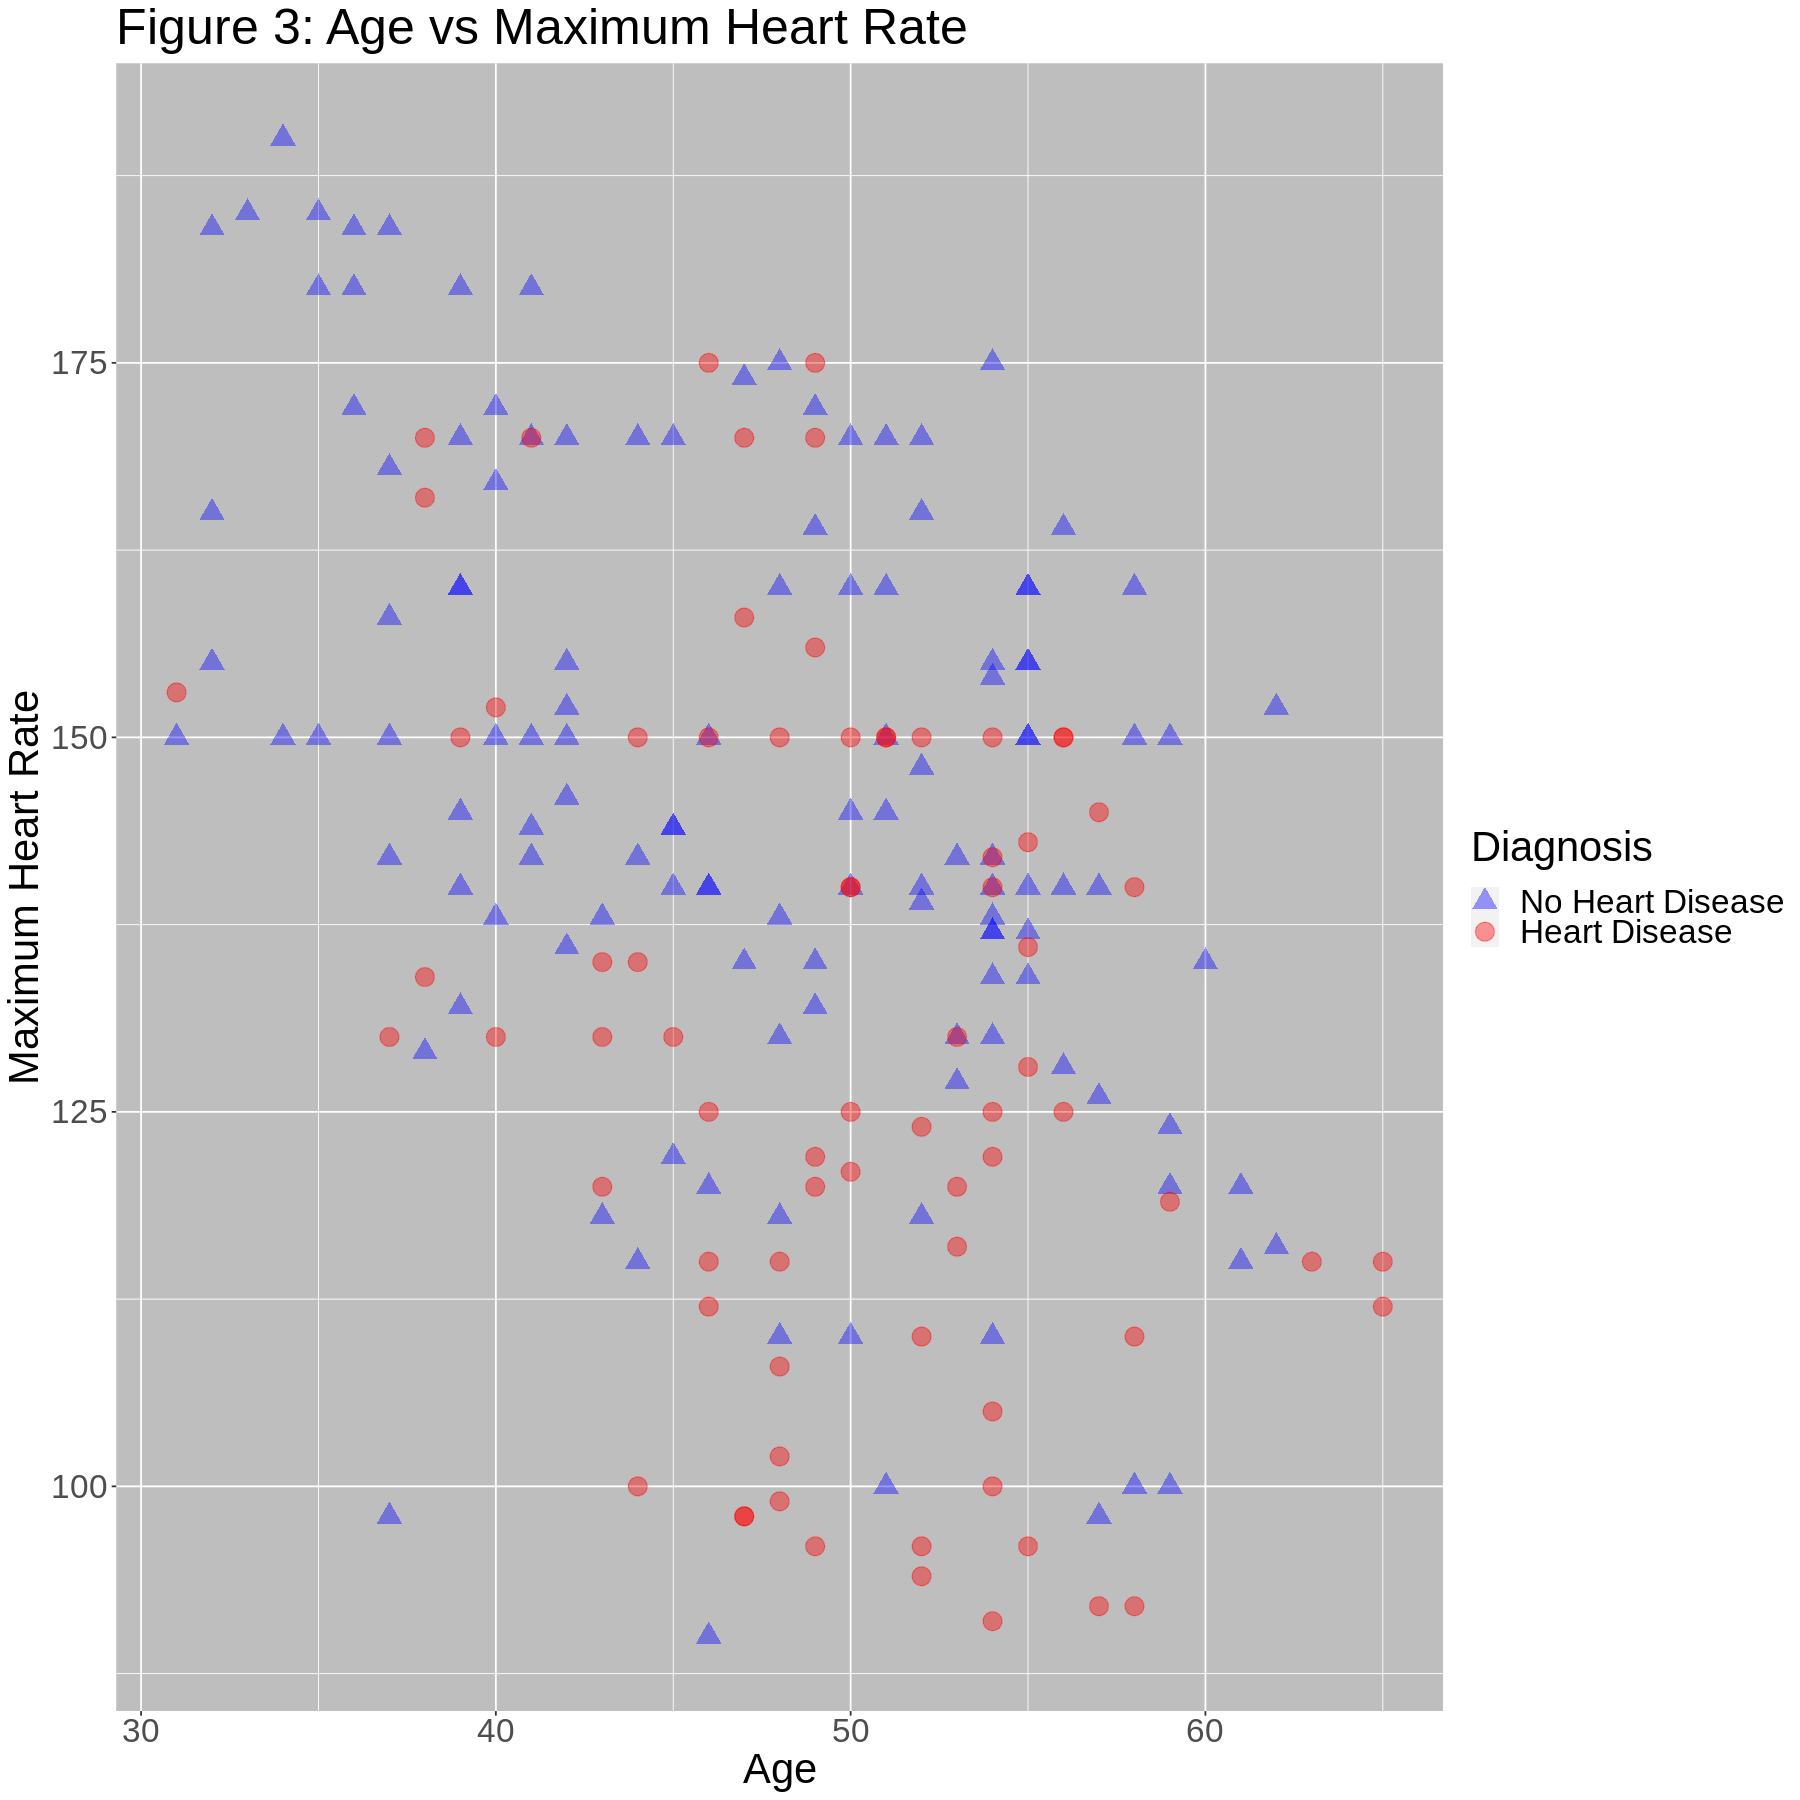

In [13]:
options(repr.plot.width = 15, repr.plot.height = 15)
max_heart_rate_vs_cholestoral_plot <- training_heart_data |>
    ggplot(aes(x = age, y = as.numeric(max_heart_rate), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Age", y = "Maximum Heart Rate", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 25), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Figure 3: Age vs Maximum Heart Rate")
max_heart_rate_vs_cholestoral_plot

This plot shows that patients with higher maximum heart rate are diagnosed less often. Older patients are diagnosed more often. Maximum heart rate and age appear to have a weak negative correlation.

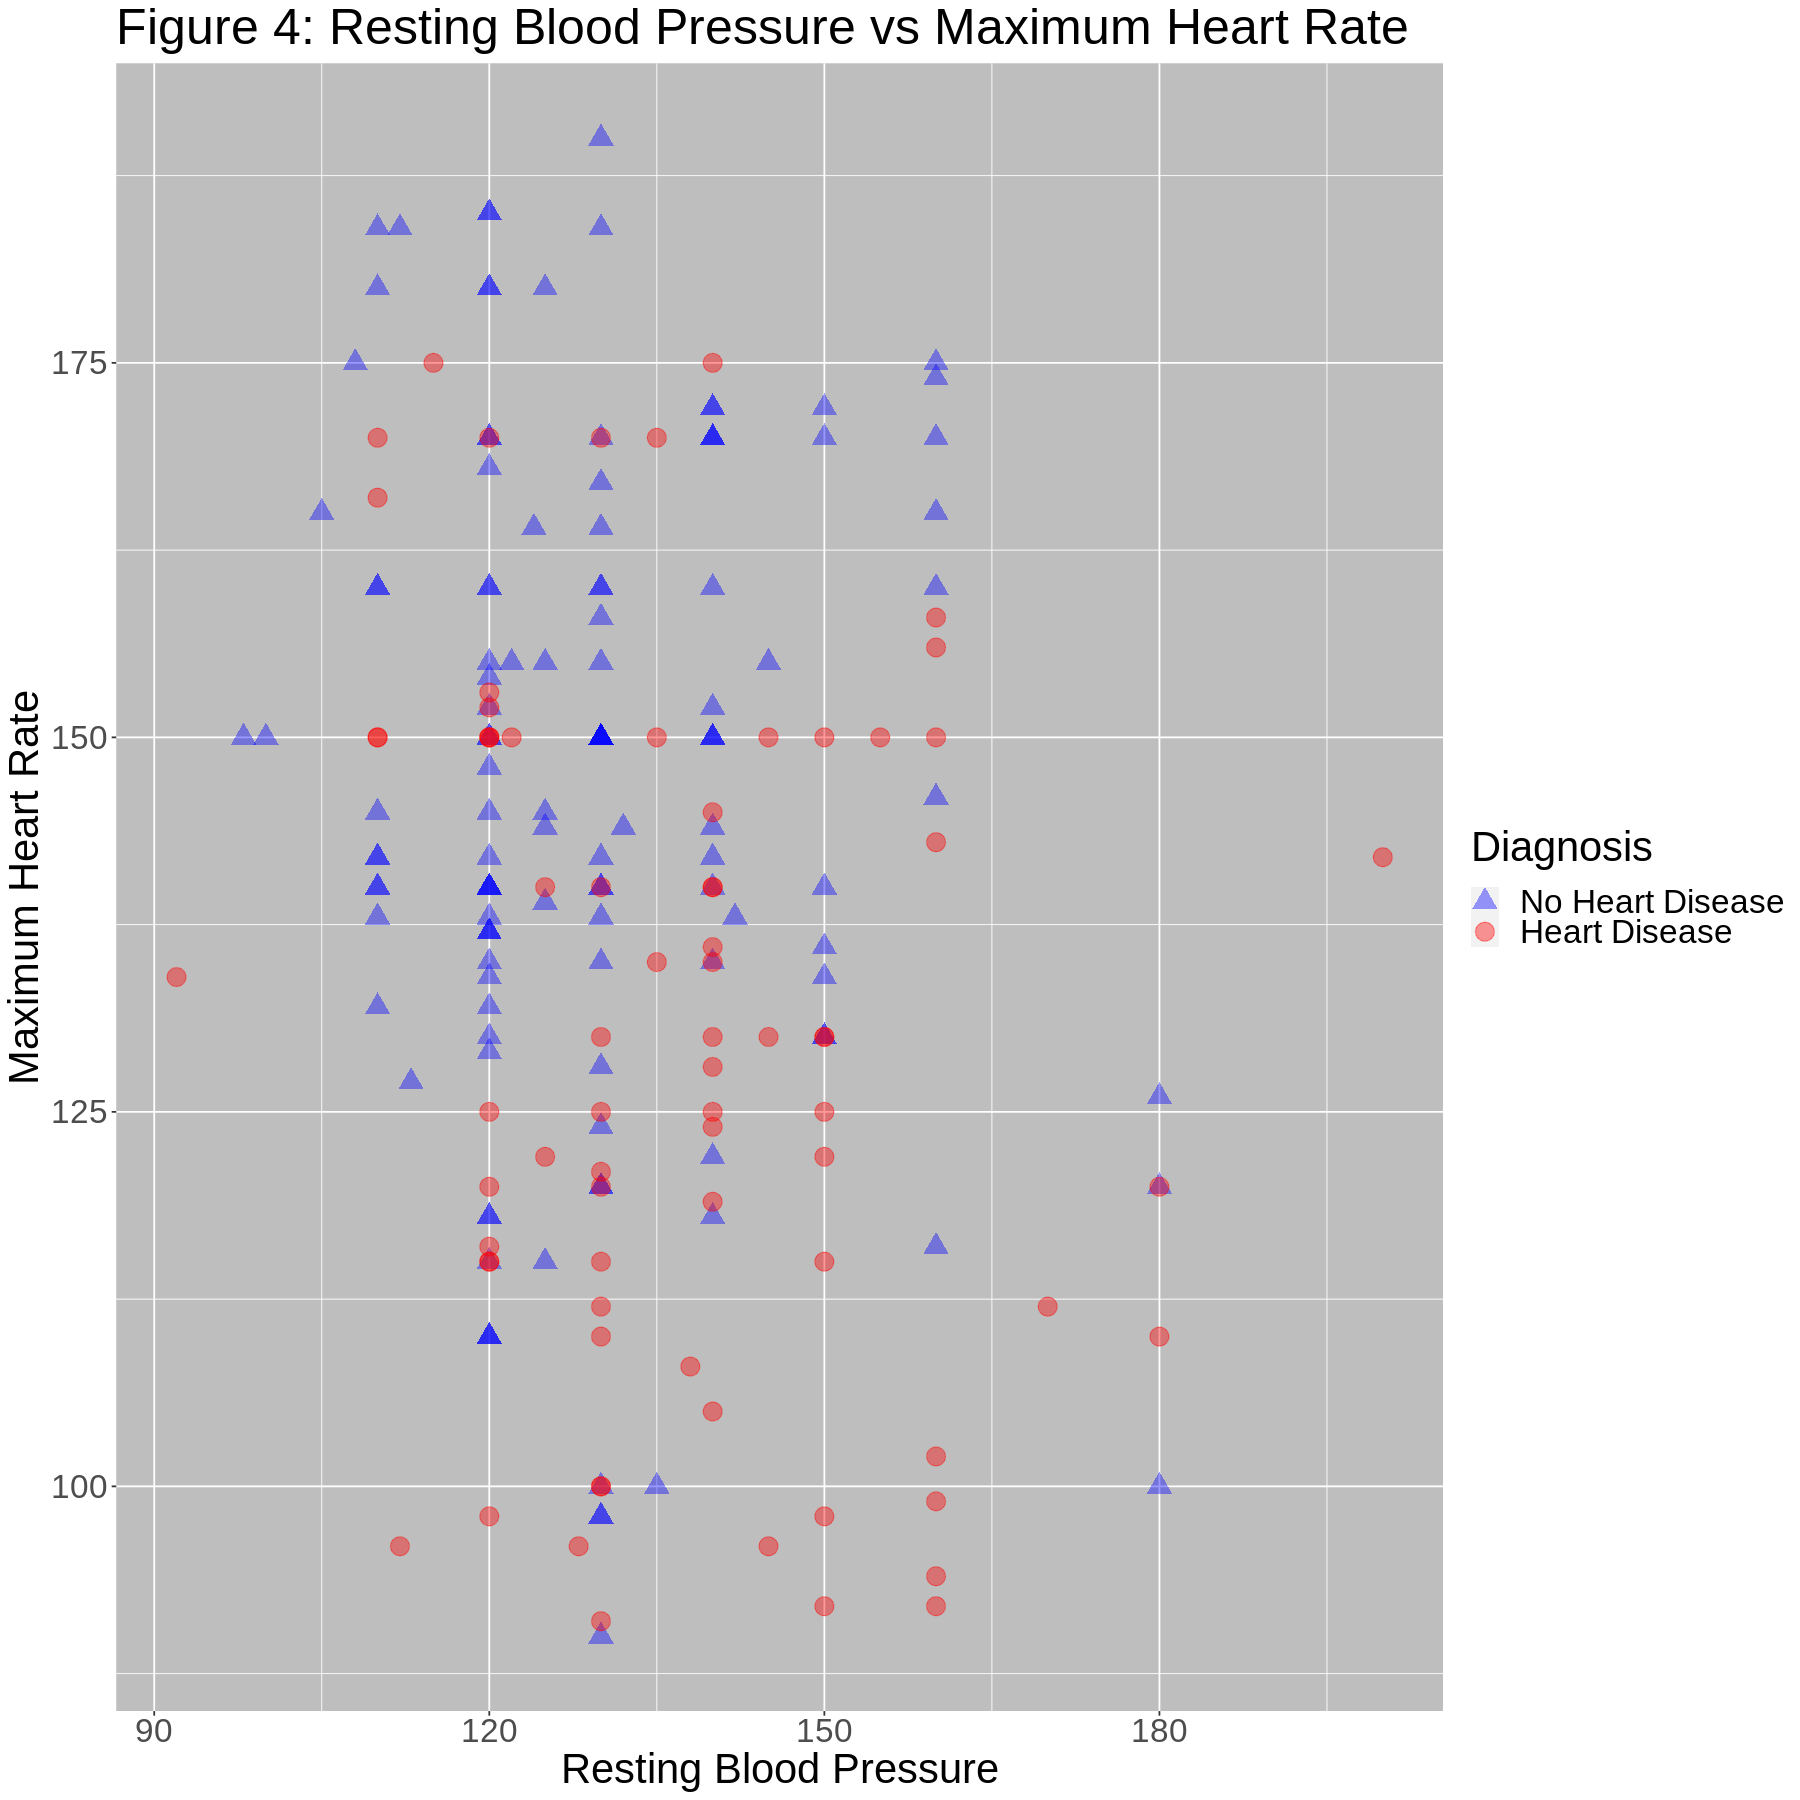

In [14]:
options(repr.plot.width = 15, repr.plot.height = 15)
resting_blood_pressure_vs_max_heart_rate_plot <- training_heart_data |>
    ggplot(aes(x = as.numeric(resting_blood_pressure), y = as.numeric(max_heart_rate), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Resting Blood Pressure", y = "Maximum Heart Rate", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 25), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Figure 4: Resting Blood Pressure vs Maximum Heart Rate")
resting_blood_pressure_vs_max_heart_rate_plot

This plot shows that there does not appear to be a relationship between resting blood pressure and maximum heart rate as the points are fairly evenly distributed according to the diagnosis. 

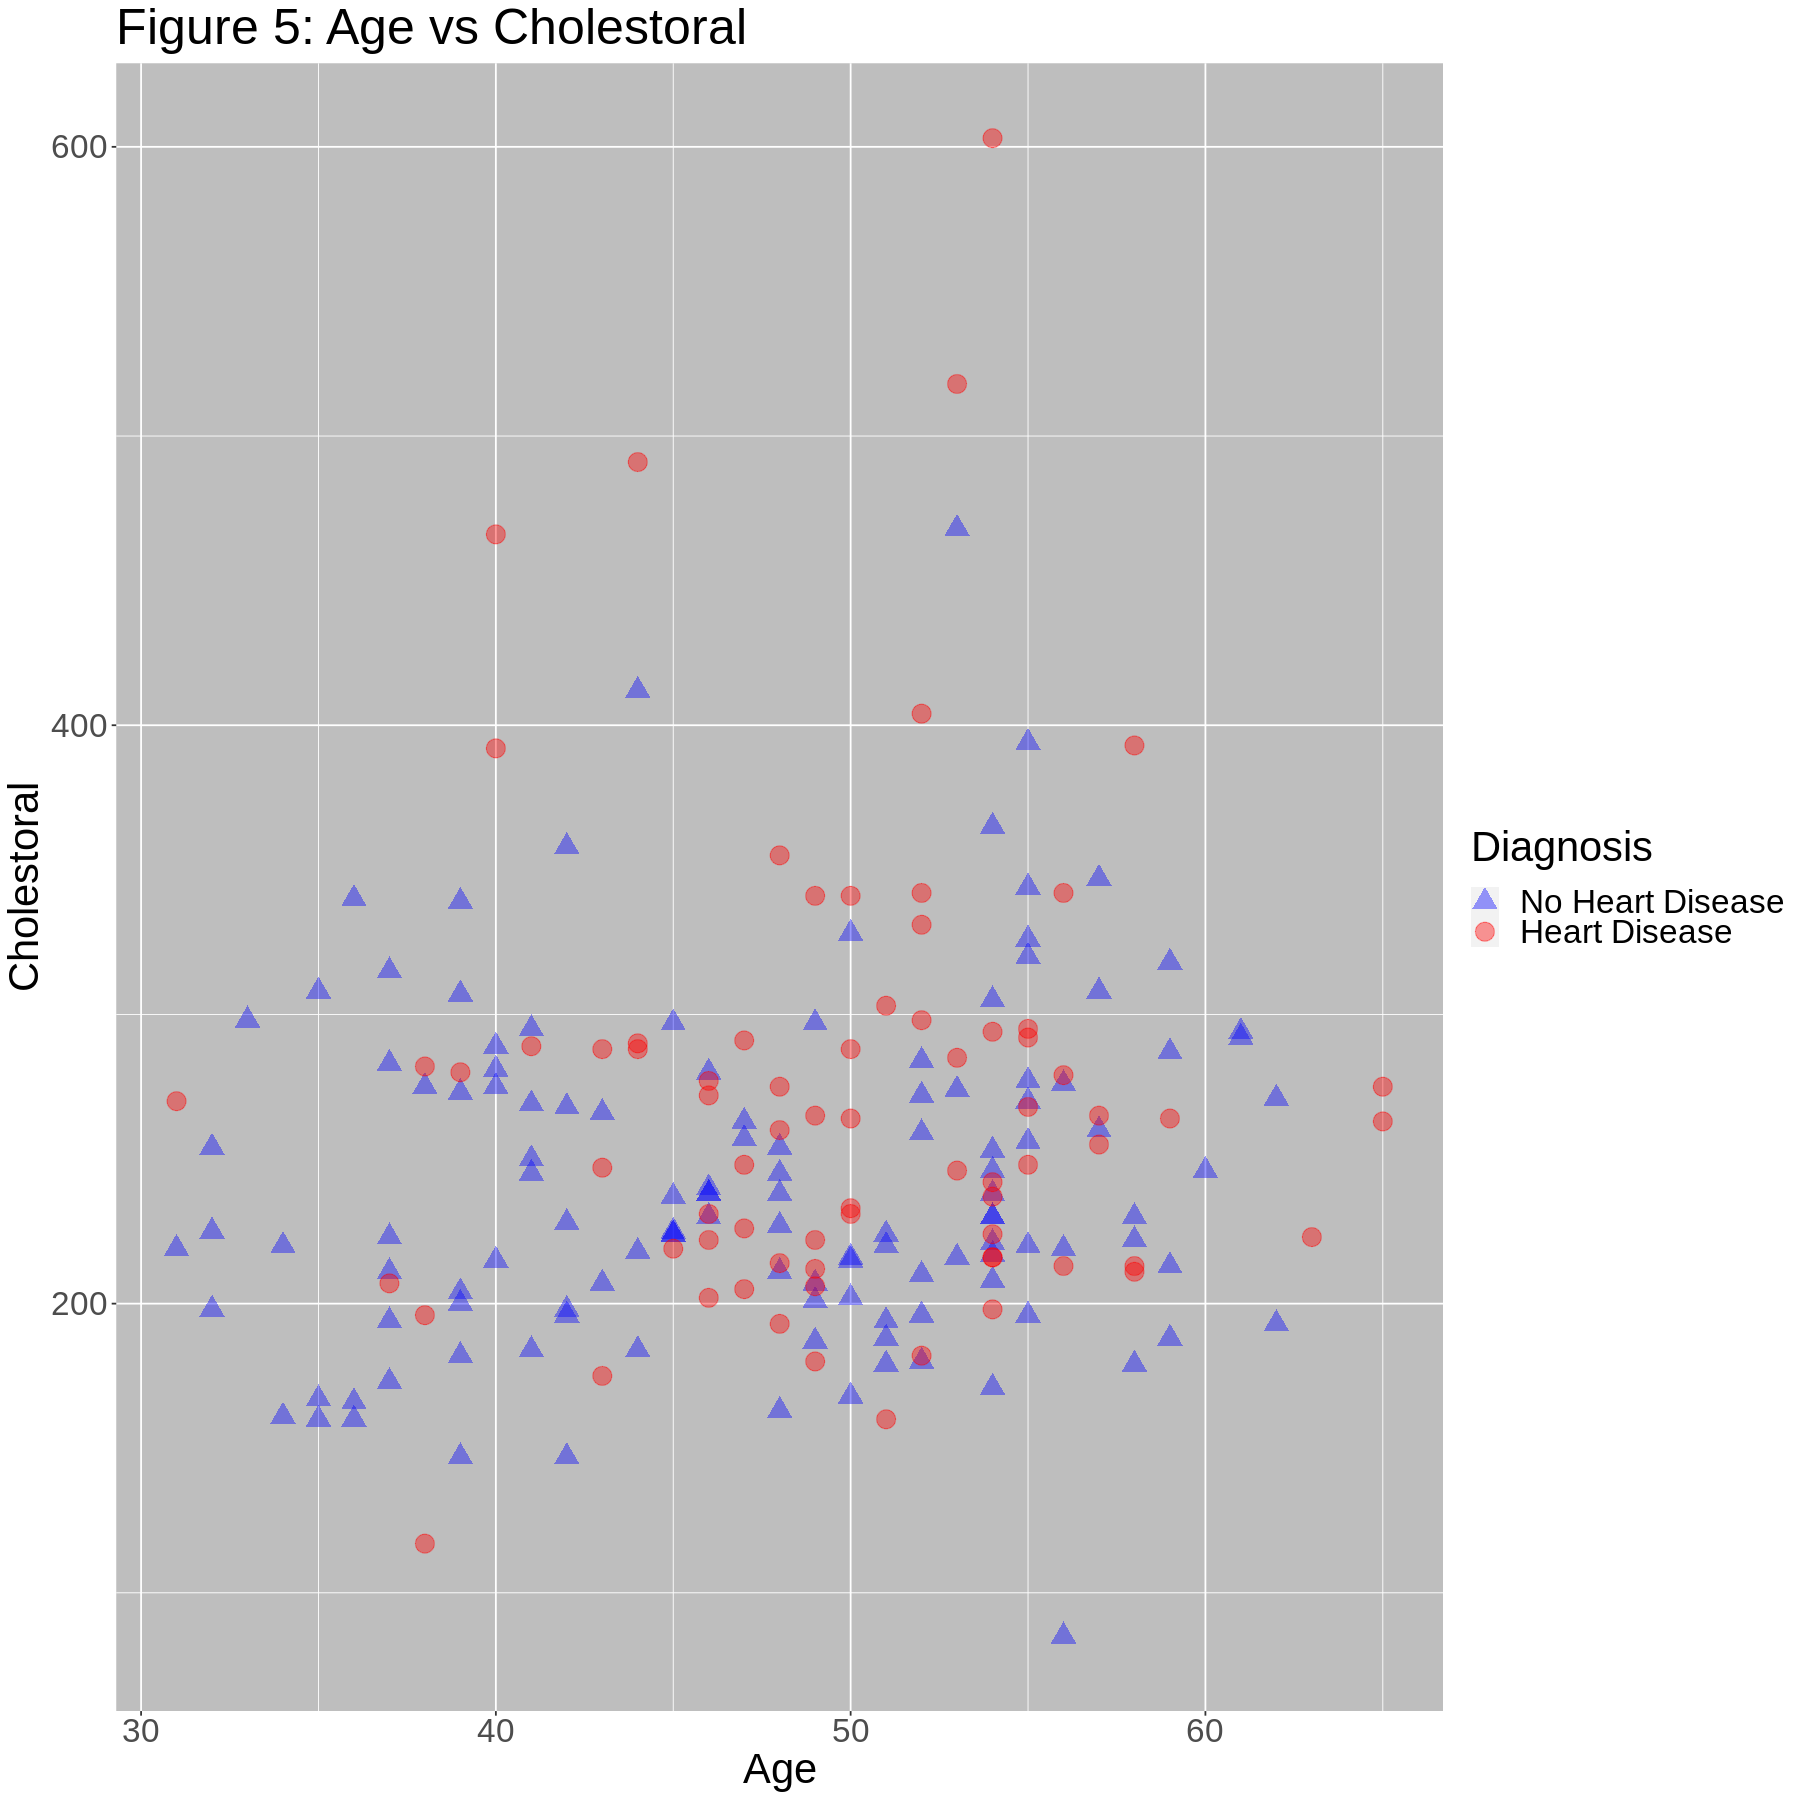

In [15]:
options(repr.plot.width = 15, repr.plot.height = 15)
age_vs_cholestoral_plot <- training_heart_data |>
    ggplot(aes(x = age, y = as.numeric(serum_cholestoral), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Age", y = "Cholestoral", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 25), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Figure 5: Age vs Cholestoral")
age_vs_cholestoral_plot

Older patients are diagnosed more often. Patients with higher cholesterol are also diagnosed more often. There is no relationship between cholesterol and age in relation to the diagnosis. 

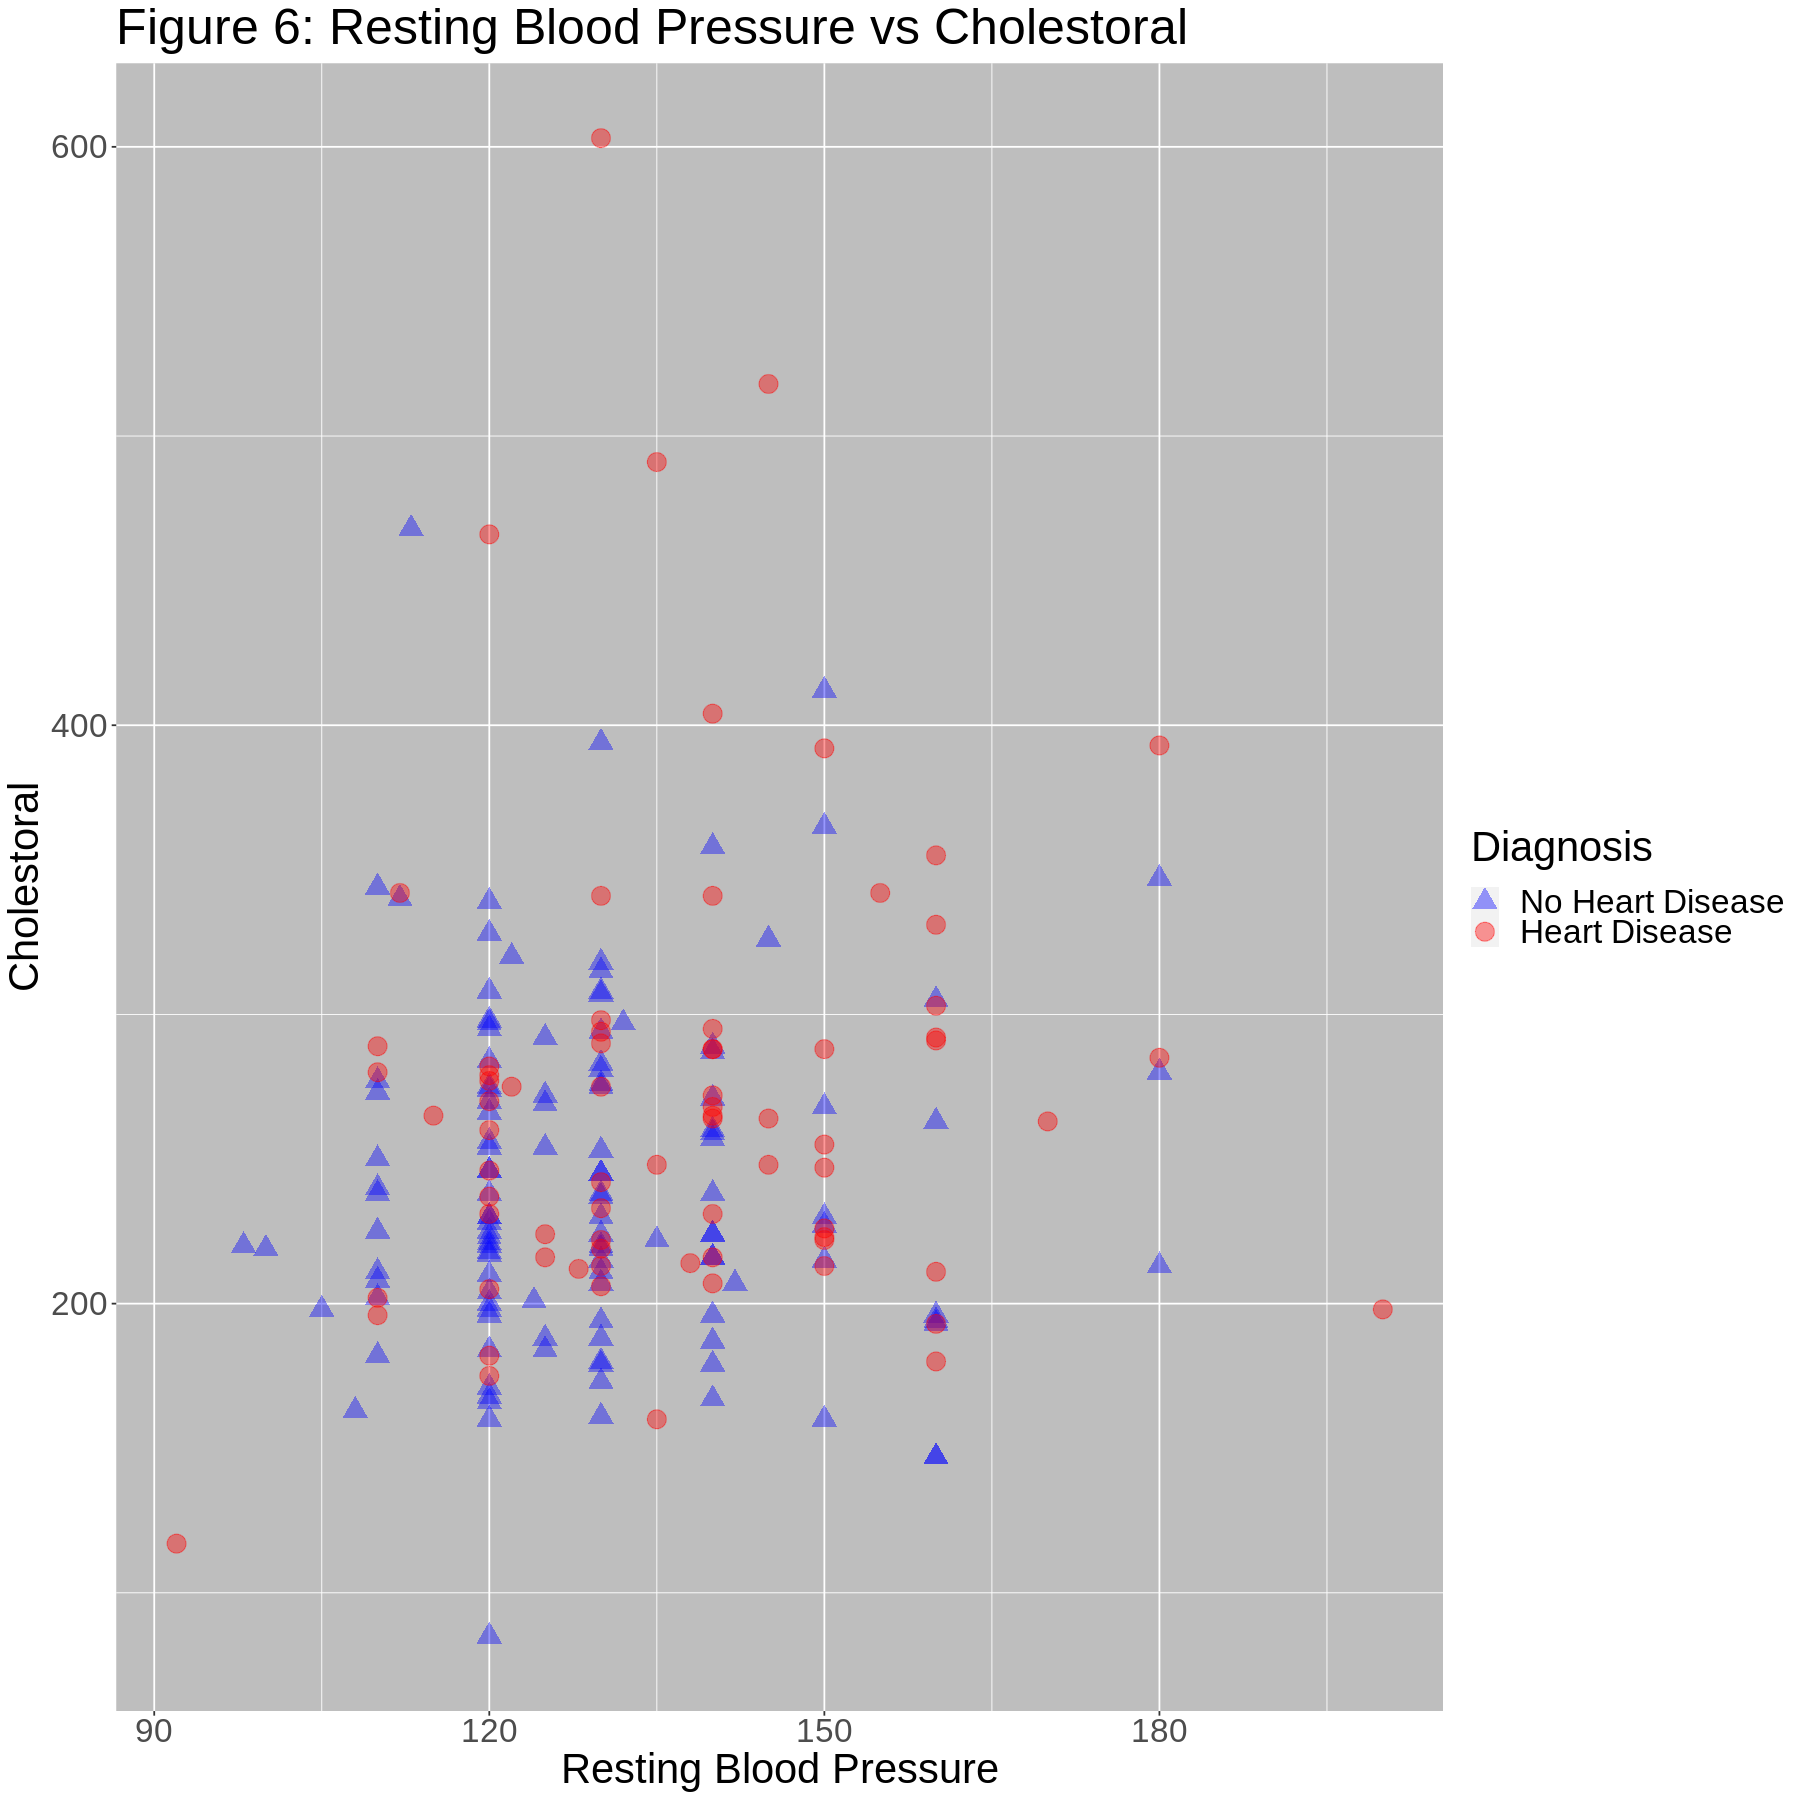

In [16]:
options(repr.plot.width = 15, repr.plot.height = 15)
cholestoral_vs_resting_blood_pressure_plot <- training_heart_data |>
    ggplot(aes(x = as.numeric(resting_blood_pressure), y = as.numeric(serum_cholestoral), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Resting Blood Pressure", y = "Cholestoral", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 25), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Figure 6: Resting Blood Pressure vs Cholestoral")
cholestoral_vs_resting_blood_pressure_plot


This plot shows that there is no correlation between cholesterol and resting blood pressure in relation to diagnosis.

**METHODS**

After examining the scatterplots showing the relationships between the potential numeric predictor variables and the response variable, we conclude that our classifier will be based on the following predictor variables: age and maximum heart rate. This is because both age and maximum heart rate together show a correlation to heart disease diagnosis. For example, graphs 1, 3, and 5 show that older patients are more often diagnosed with heart disease while graphs 2, 3, and 4 show that patients with lower maximum heart rate are more often diagnosed. These are both good predictors of heart disease because older people tend to have lower maximum heart rate which increases the risk of heart disease (Harvard Health, 2020). 

We will create our model by first standardizing the predictor variables by scaling and centering with a recipe. Then, we will tune the model for the most accurate K value using 5-fold cross validation with the training data. After selecting K, we will train the model on the training set and then use it to predict the classes of the testing set to test its accuracy. Lastly, we will visualize our model's accuracy with a confusion matrix table and a bar graph showing which diagnoses were correctly or incorrectly predicted. 

**KNN MODEL**

Now that we have chosen age and maximim heart rate to be the predictor variables for the classification model, we select these desired variables from the training and testing data. 

In [116]:
heart_train <- training_heart_data |> 
    mutate(age = as.numeric(age), max_heart_rate = as.numeric(max_heart_rate))|>
    select(age, max_heart_rate, diagnosis)
    head(heart_train)

heart_test <- testing_heart_data |>
    mutate(age = as.numeric(age), max_heart_rate = as.numeric(max_heart_rate))|>
    select(age, max_heart_rate, diagnosis)
    head(heart_test)

age,max_heart_rate,diagnosis
<dbl>,<dbl>,<fct>
31,150,0
32,165,0
32,184,0
32,155,0
33,185,0
34,190,0


age,max_heart_rate,diagnosis
<dbl>,<dbl>,<fct>
28,185,0
29,160,0
30,170,0
34,168,0
35,168,0
36,178,0


We must first create a recipe that will center and scale the training data. This ensures that each predictor variable contributes equally to the model classifications by giving the observations a standard deviation of 1 and a mean of 0. We do not choose to include upsampling to balance the ratio of observations because our preliminary analysis shows that 62% of the observations do not have heart disease (value 0) compared to 37% that have heart disease (value 0) which is relatively balanced and will not significantly impact the model.  

In [117]:
heart_recipe <- recipe(diagnosis ~ age + max_heart_rate, data = new_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
heart_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

The, we create a knn model specification where the engine is set to "kknn" and the mode is set to "classification". We use tune() in the neighbours argument because we are initially going to tune the model to choose the best K value. The weight_func argument is set to "rectangular" so that each neighbor has 1 vote in the majority vote. 

In [119]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Now, we will initially tune the model to choose the most optimal number of neighbours to maximize its accuracy. We will do this by peforming 5 fold cross validation for a range of k values. We choose 5 splits because shoosing a higher number of splits will increase the computation time. We create a 5 fold cross validation object that splits the training data into 5 equal splits. 

In [113]:
vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)

Next, we combine the recipe and model specification into a workflow that will test a range of K values using 5 fold cross validation. We specify the range of K values to choose in the kvals object. We incorporate collect_metrics() so that we can view the accuracies of each K value and compare them. The collect_metrics() function contains irrelevant information aside from the accuraties so we filter the dataframe. We now have a dataframe that contains the accuracy of the model performance for each K value using cross validation.

In [123]:
kvals <- tibble(neighbors = seq(from = 1, to = 80, by = 10))

knn_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_tune) |> 
    tune_grid(resamples = vfold, grid = kvals) |> 
    collect_metrics()|>
    filter(.metric == "accuracy")
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6118293,5,0.02218255,Preprocessor1_Model1
11,accuracy,binary,0.6965854,5,0.01169016,Preprocessor1_Model2
21,accuracy,binary,0.6614634,5,0.01785805,Preprocessor1_Model3
31,accuracy,binary,0.6764634,5,0.01441993,Preprocessor1_Model4
41,accuracy,binary,0.6614634,5,0.02385183,Preprocessor1_Model5
51,accuracy,binary,0.6664634,5,0.01943583,Preprocessor1_Model6
61,accuracy,binary,0.6763415,5,0.02313733,Preprocessor1_Model7
71,accuracy,binary,0.6317073,5,0.01036765,Preprocessor1_Model8


Then we plot each K value against its accuracy so that we can choose the most accurate K value for our final model. 

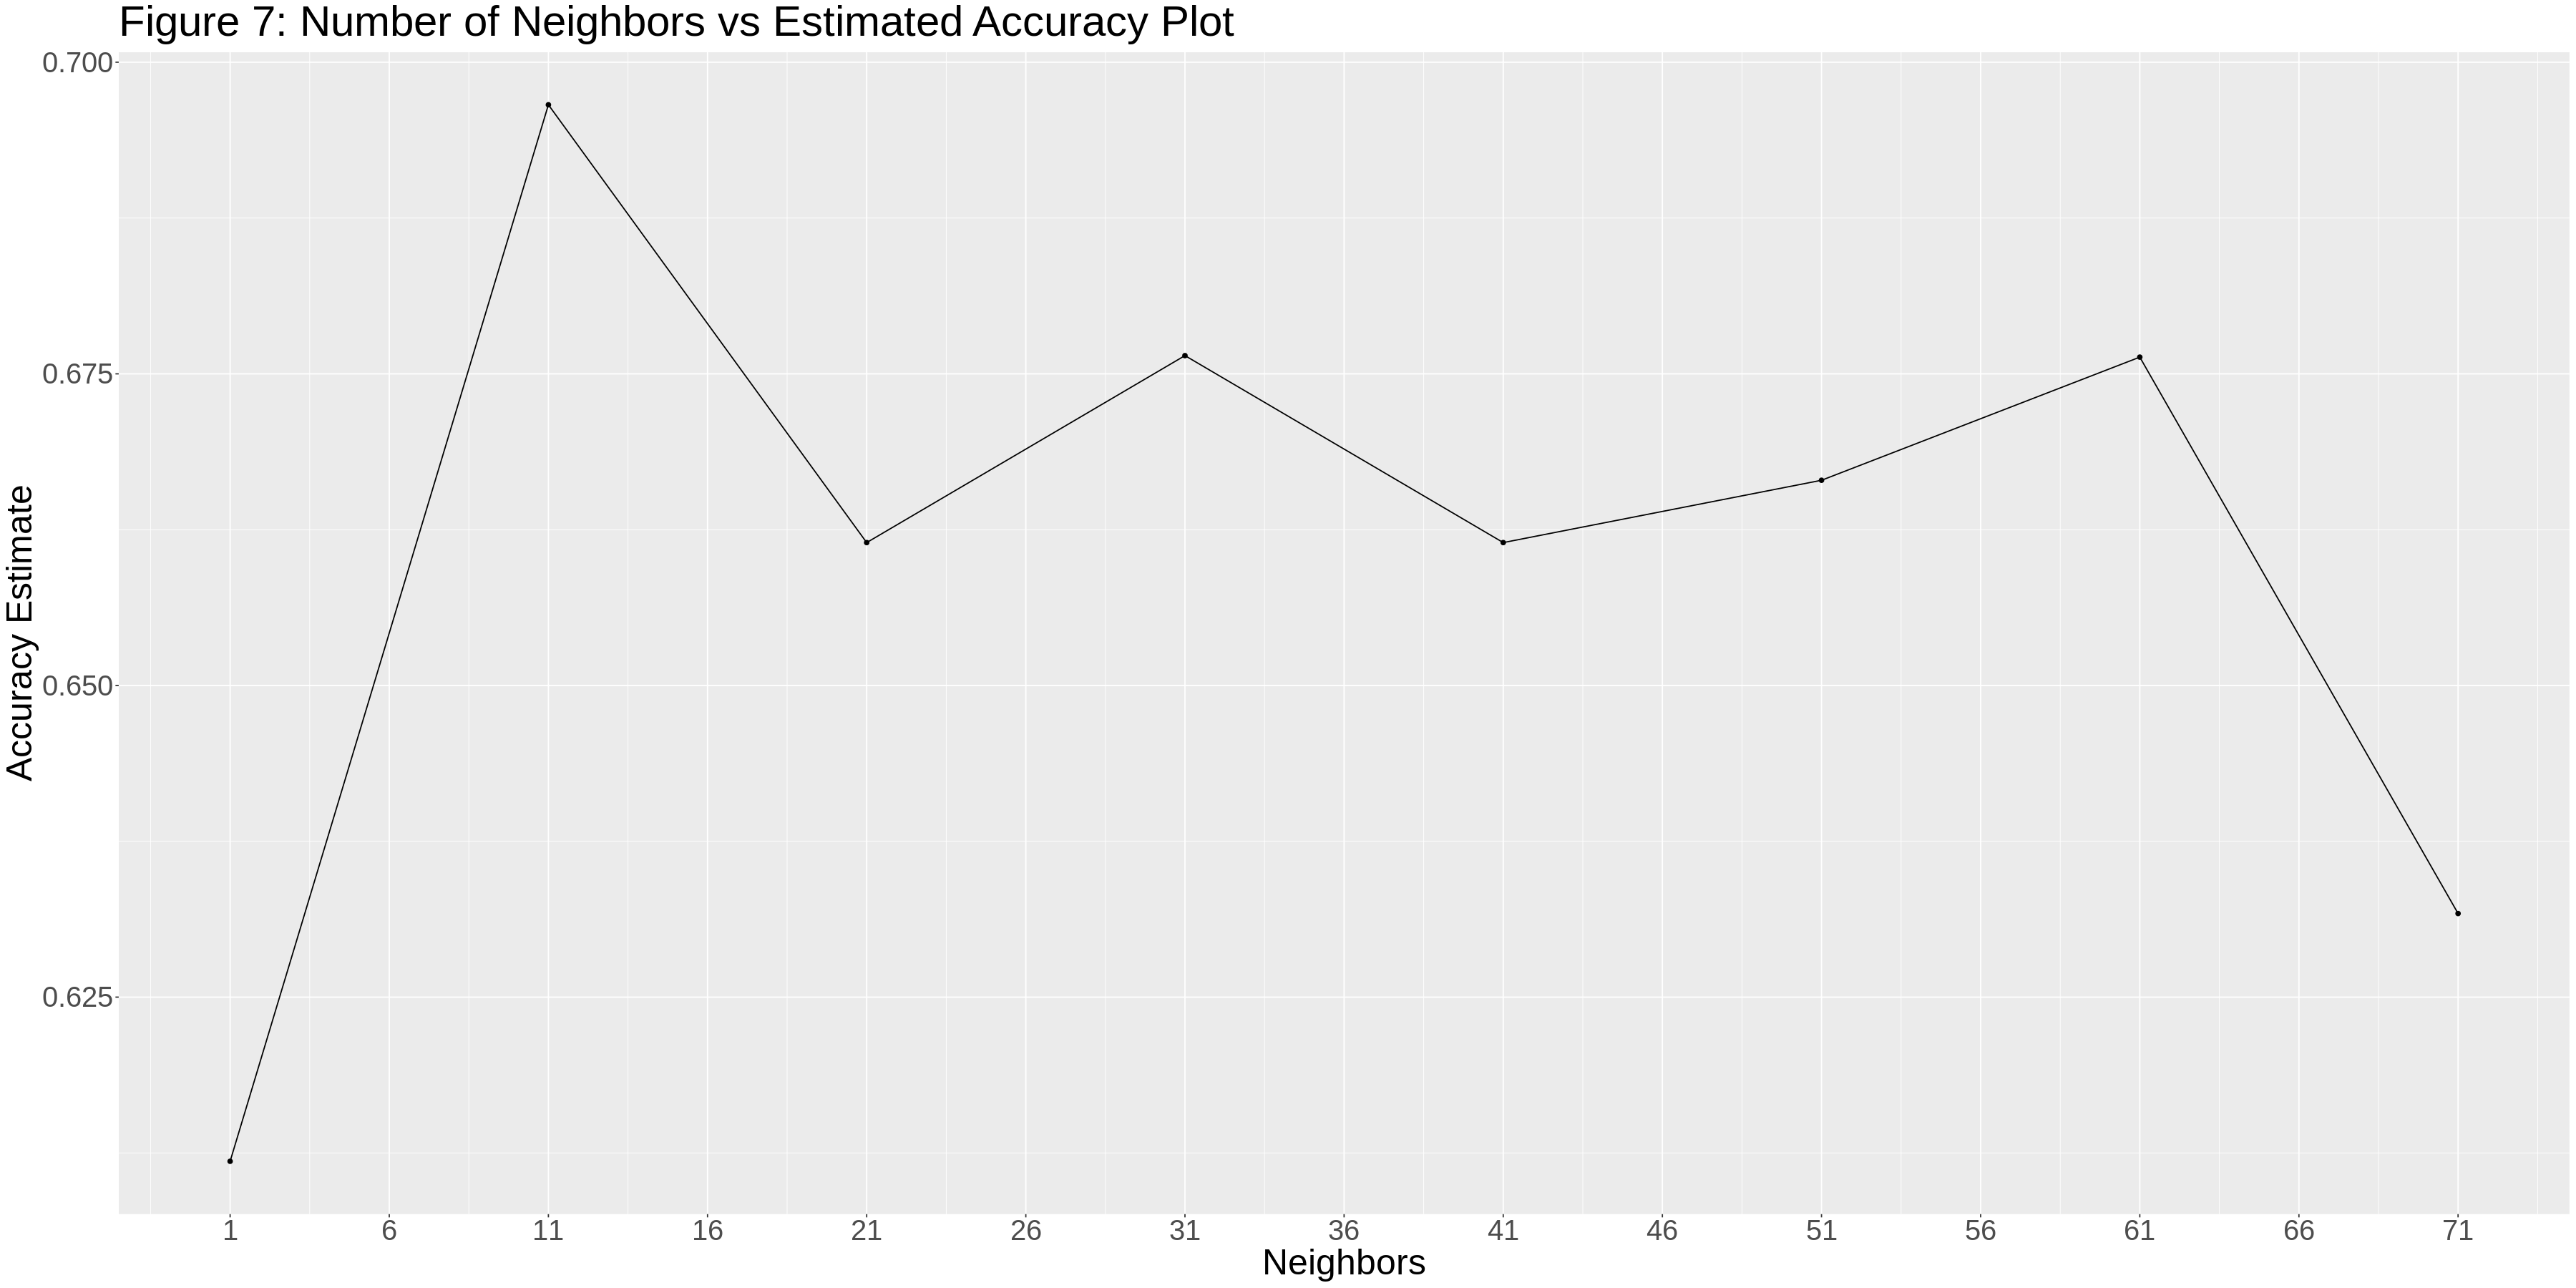

In [124]:
options(repr.plot.width = 30, repr.plot.height = 15)

accuracy_vs_k <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Figure 7: Number of Neighbors vs Estimated Accuracy Plot") +
    scale_x_continuous(breaks = seq(from = 1, to = 80, by = 5)) +
    theme(text = element_text(size = 30))
accuracy_vs_k

According to the graph, k=11 reports an accuracy of 69.65%. Hence, we choose 11 neighbors for our model because it the number of neighbors that provides the most accurate predictions.

Now we will create a new model specification with our selected k value that has been saved to an object. We use the same recipe created above and add it into a workflow, fitting it to the training data. 

In [127]:
k <- 11

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = k) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_spec_2

knn_fit <- workflow() |> 
    add_recipe(heart_recipe) |> 
    add_model(knn_spec_2) |> 
    fit(data = heart_train)
knn_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = k
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3383085
Best kernel: rectangular
Best k: 11

We can now evaluate the accuracy of the model by using it to test on the testing data. After filtering for accuracy, we can create a confusion matrix that will the number of incorrect and correct predictions based on the true observation class. 

In [130]:
heart_test_preds <- predict(knn_fit, heart_test) |>
    bind_cols(heart_test)
glimpse(heart_test_preds)

heart_preds_accuracy <- heart_test_preds |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")
heart_preds_accuracy

confusion_matrix <- heart_test_preds |>
    conf_mat(truth = diagnosis, estimate = .pred_class)
confusion_matrix

Rows: 69
Columns: 4
$ .pred_class    <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ age            <dbl> 28, 29, 30, 34, 35, 36, 37, 38, 38, 39, 41, 41, 42, 43,…
$ max_heart_rate <dbl> 185, 160, 170, 168, 168, 178, 130, 150, 130, 106, 160, …
$ diagnosis      <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6086957


          Truth
Prediction  0  1
         0 33 17
         1 10  9

This confusion matrix tells us that 42 predictions were correct and 27 were incorrect out of a total of 69 predictions. This model has an accuracy of 60.87%. There were 20 patients with heart disease that were predicted to not have it which is a large amount of misses (20 missed out of the 26 patients with heart disease in the testing data). On the other hand there were only 7 out of the 43 patients without heart disease that were predicted to have it. This means our model tends toward predicting no heart disease and will miss diagnosing a lot of patients who do have heart disease.

We will now create a bar graph that can visualize the confusion matrix of the prediction errors in a way that is more human readible. 

In [131]:
conf_table <- heart_test_preds|>
    select(.pred_class, diagnosis)|>
    group_by(.pred_class, diagnosis)|>
    summarize(count = n())

`summarise()` has grouped output by '.pred_class'. You can override using the
`.groups` argument.


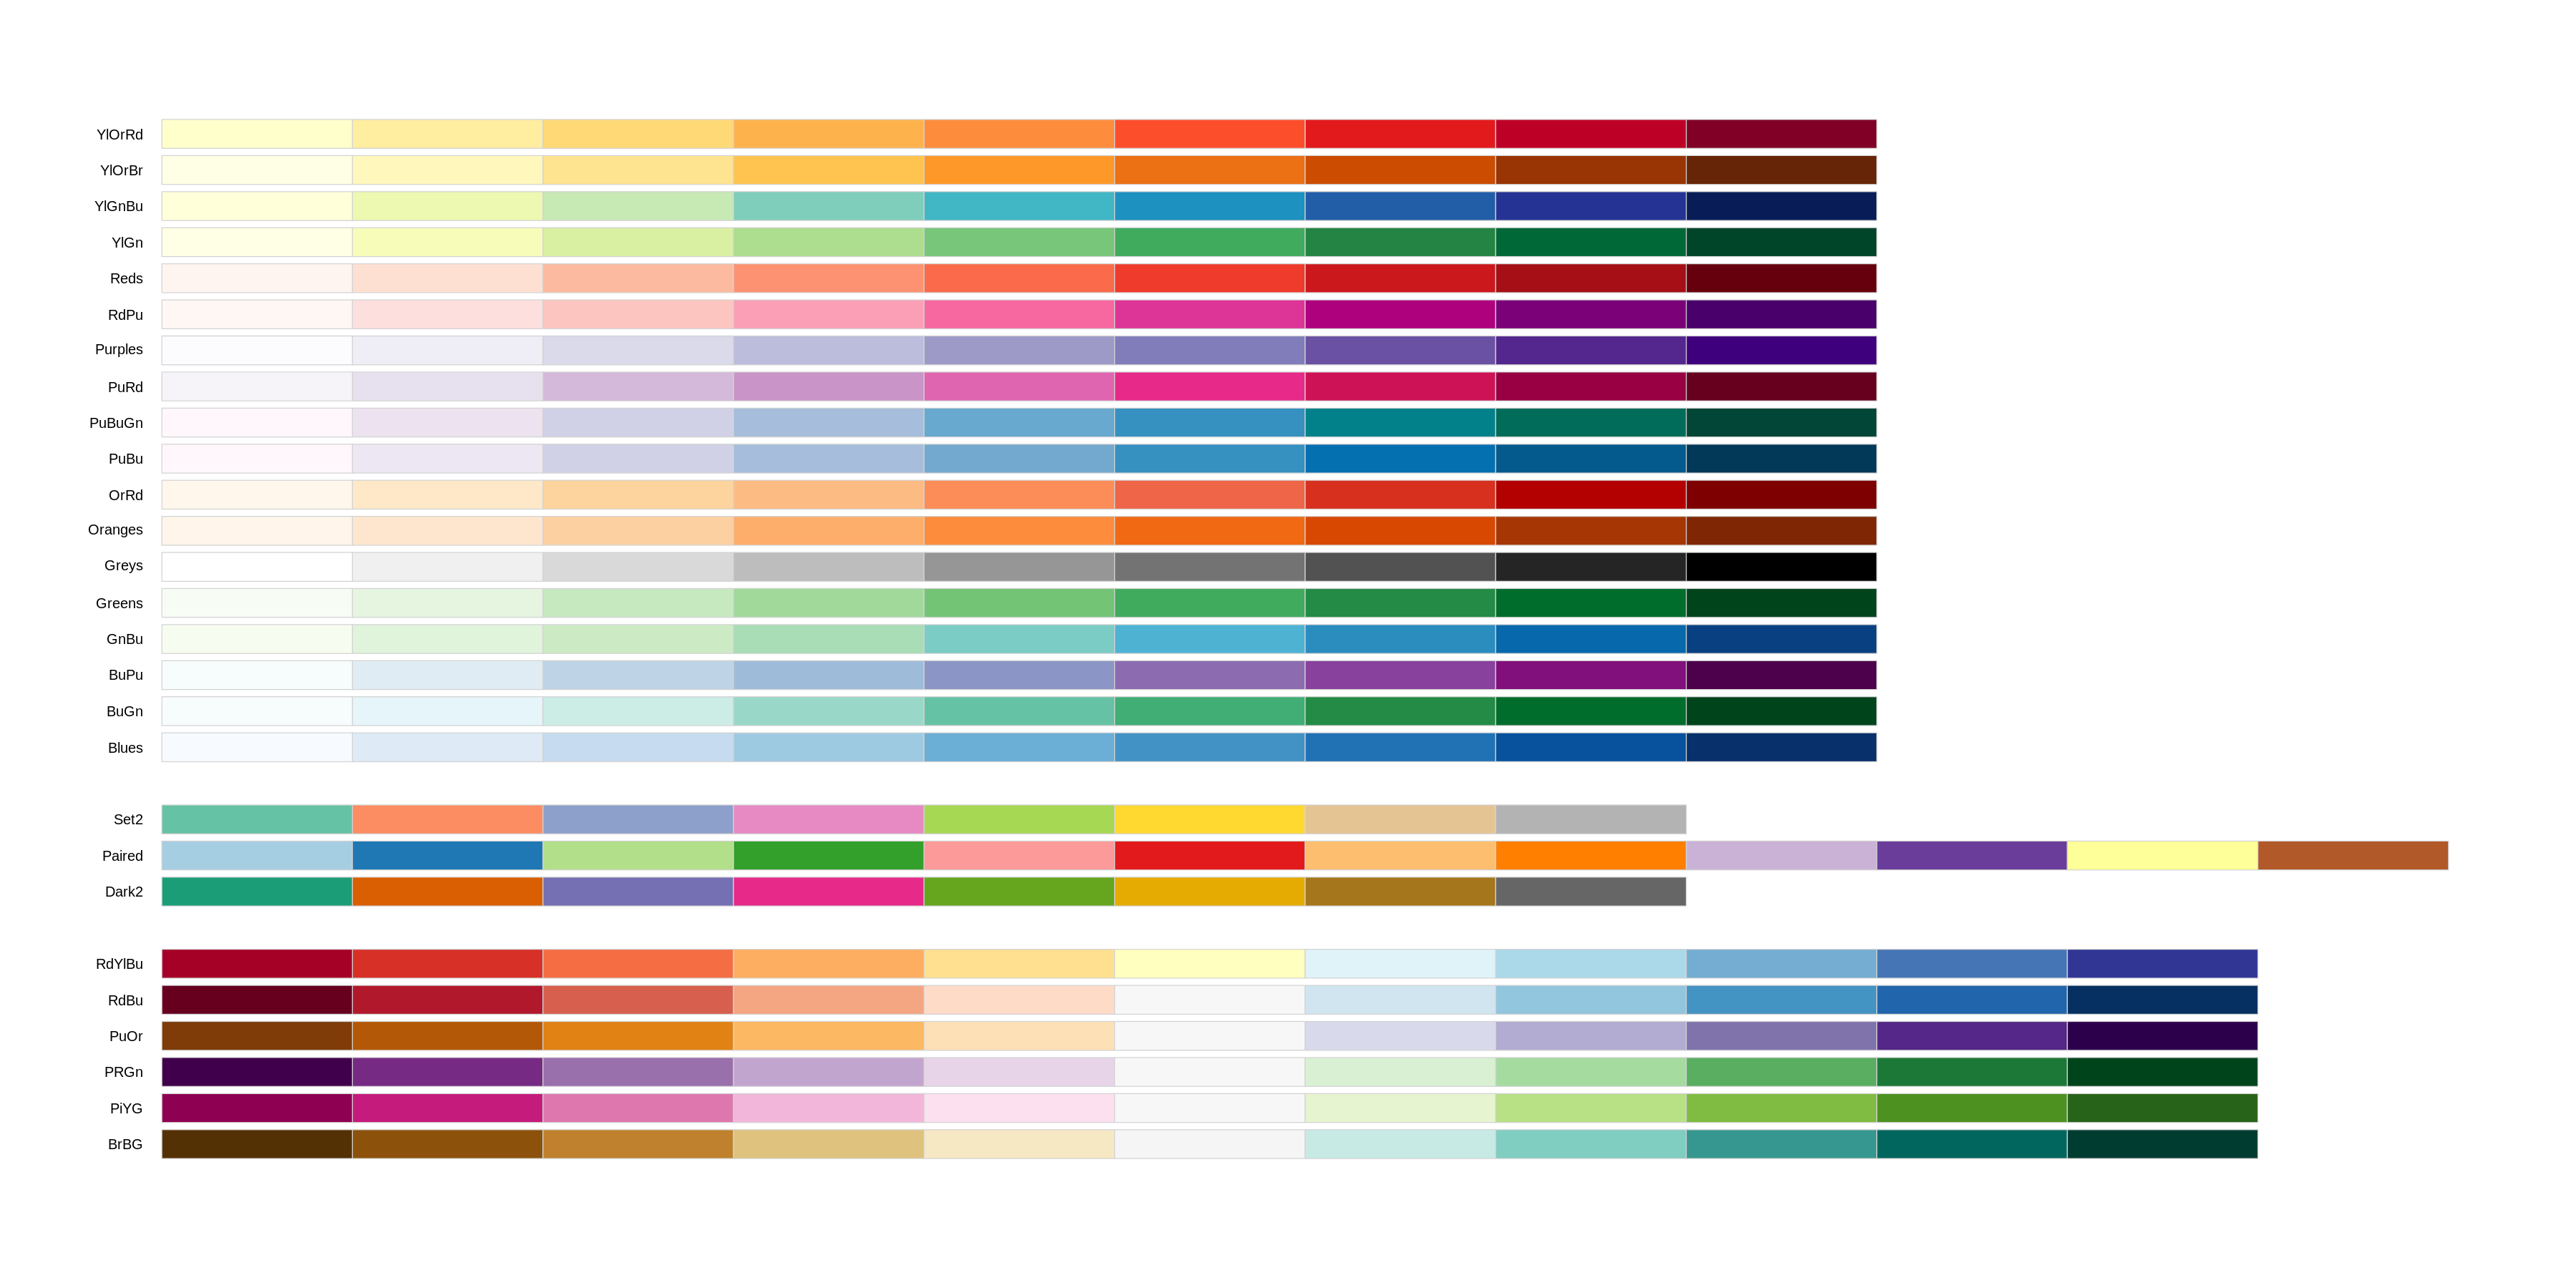

In [132]:
library(RColorBrewer)
display.brewer.all(colorblindFriendly = TRUE)

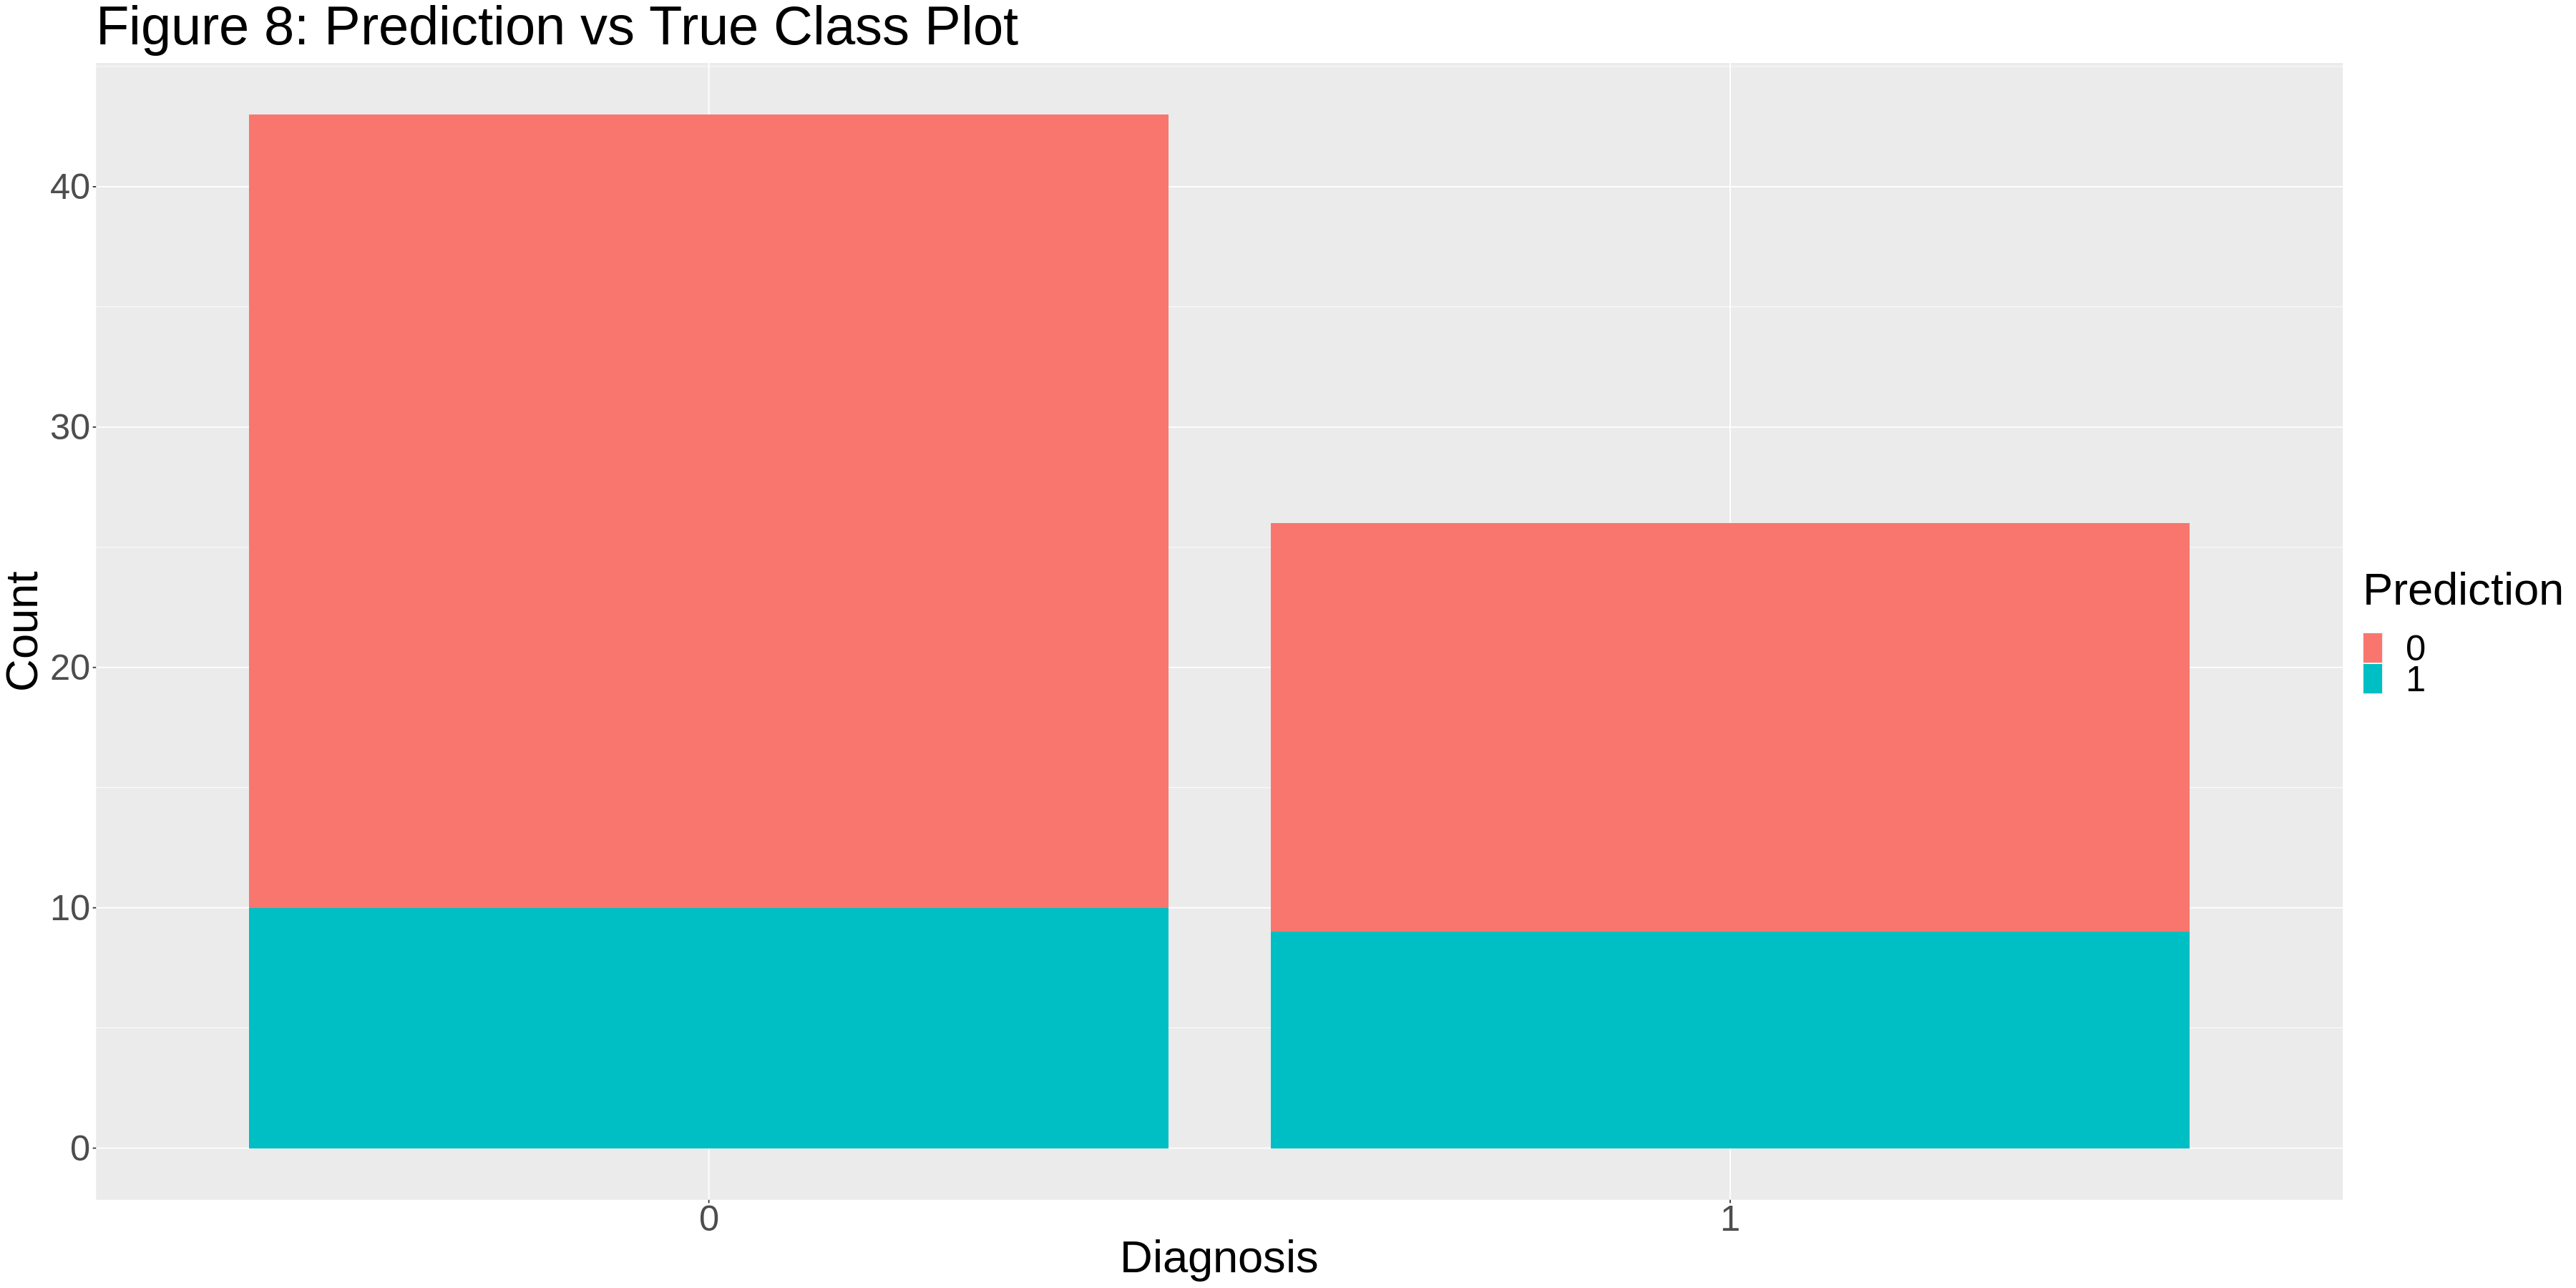

In [133]:
conf_plot <- conf_table|>
    ggplot(aes(x = diagnosis, y = count, fill = .pred_class))+
    geom_bar(stat = "identity")+
    labs(x = "Diagnosis", y = "Count", fill = "Prediction")+
    ggtitle("Figure 8: Prediction vs True Class Plot")+
    scale_color_brewer(palette = "Set2")+
    theme(text = element_text(size = 38))
conf_plot

#not sure why the colours arent adding to the plot

This graph shows same information as the confusion matrix.

The bar on the left shows that the total number of observations with a true class of no heart disease (value = 0) is 43. Out of these observations, the model predicted that 7 of these observations were incorrectly predicted to have heart disease. The model correctly predicted that 36 of these observations have no heart disease.

The bar on the right shows that the total number of observations with a true class of heart disease (value = 1_ is 26. Out of these observations, the model incorrectly predicted that 21 of them had no heart disease. The model correctly predicted that 5 of them have heart disease. 

This means that the model is better at predicting on new observations that do not have heart disease than it is at predicting on new observations that have heart disease. This has implications for the application of this model becuase it is worse in a clinical setting to incorrectly predict that a patient has no heart disease when they really do have heart disease. 


**OUTCOMES AND SIGNIFICANCE** 

In conclusion, our model has an accuracy of 69.65% when tested on the testing data. We can compare this to the majority classifier to determine whether its performance is significant. The majority clasifier would always predict new observations to have no heart disease with an accuracy of 62.66%. However, while our model has a higher accuracy than the majority classifier, it does not have a high accuracy when considering its implication in health care. The model incorrectly predicted 17 out of the observations that had heart disease to not have heart disease, which can be dangerous when considering thehuman health. 

We expect our classification model to accurately predict whether individuals have heart disease based on age and maximum heart rate. This is significant because it will provide faster and more accurate diagnoses for people with risk factors for heart disease. By predicting the presence of heart disease earlier, this could revolutionize healthcare through early administration of treatment regimens. 

Further questions include whether other variables aside from those in the Hungarian data set contribute to heart disease and could improve the accuracy of our model. We could also question whether incorporating data from other countries into our model would increase it's accuracy.

To improve our model we could look at the clustering data for the variables to pick variables that show the most clear differences between those with and without heart disease.


**REFERENCES**

World Health Organization. (n.d.). Cardiovascular diseases. World Health Organization. Retrieved March 10, 2023, from https://www.who.int/health-topics/cardiovascular-diseases/ 

Centers for Disease Control and Prevention. (2022, July 12). About heart disease. Centers for Disease Control and Prevention. Retrieved March 10, 2023, from https://www.cdc.gov/heartdisease/about.htm 

WebMD. (n.d.). High cholesterol and high blood pressure. WebMD. Retrieved March 10, 2023, from https://www.webmd.com/cholesterol-management/high-cholesterol-and-high-blood-pressure 

UCI Machine Learning Repository: Heart disease data set. (n.d.). Retrieved March 10, 2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

What your heart rate is telling you. Harvard Health. (2020, August 30). Retrieved March 11, 2023, from https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you